<a href="https://colab.research.google.com/github/DeboBuiz/MSc-Thesis/blob/main/MS_Thesis_HA_Candle_prediction_ver_6_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Common Functions and Libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime
import math
import seaborn as sns

#Packages required for graphs
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D

#sklearn libraries
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

#common function
def joinMultipleDataLists(dataLists):
  joinedList = []
  for dataList in dataLists:
    joinedList.extend(dataList)
  return joinedList

#wrapper function to create XY data using the specified function
def prepareXYdata(createDataXY, *sources_of_XY
                  , scalingFunc=None, threshold=None
                  , removeUpDownValues=False
                  , **kwargsOf_XY):
  dataX, dataY, dataSupport = [],[],[]
  for source in sources_of_XY:
    x, y, support = createDataXY(source, **kwargsOf_XY)
    dataX.extend(x)
    dataY.extend(y)
    dataSupport.extend(support)
  
  dataX, dataY, dataSupport = np.array(dataX), np.array(dataY), np.array(dataSupport)

  #pre-clean data
  dataX, dataY, dataSupport, removedIndices = removeBadSamples([dataX, dataY, dataSupport])

  #required during inverse scaling if scaling is applied
  nonScaled_dataX = dataX
  nonScaled_dataY = dataY

  #apply necessary scaling function
  if scalingFunc != None:
    dataX, dataY = scalingFunc(dataX, dataY)
    dataX, dataY, removedIndices = removeBadSamples([dataX, dataY], threshold=threshold)
    dataSupport, nonScaled_dataX, nonScaled_dataY, removedIndices = removeBadSamples([dataSupport, nonScaled_dataX, nonScaled_dataY], removeIndices=removedIndices)
  
  #remove up_Close and down_Close from features
  if removeUpDownValues:
    dataX = dataX[:,0:-2]

  return dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY

#clean samples
def removeBadSamples(data2D_arrayList, threshold=None, removeIndices=None):
  indicesSet = set()
  if removeIndices != None:
    indicesSet = removeIndices
  else:
    for dataArray in data2D_arrayList:
      indicesSet = indicesSet.union(np.argwhere(~ np.isfinite(dataArray))[:,0])
      if threshold != None:
        indicesSet = indicesSet.union(np.argwhere(np.absolute(dataArray) > threshold)[:,0])
    
  cleanArrayList = []
  for dataArray in data2D_arrayList:
    cleanArrayList.append(np.delete(dataArray, list(indicesSet), axis=0))
  #returns all the cleaned arrays and indices that were removed
  cleanArrayList.append(indicesSet)
  return tuple(cleanArrayList)


def identifyCandleColor(openSeries,closeSeries,RED=0,GREEN=1):
  if len(openSeries) != len(closeSeries):
    raise Exception(f'Error: Length of openSeries is not equal to lenght of closeSeries')

  colorOfCandles = []
  for i in range(len(openSeries)):
    color = GREEN if closeSeries[i] >= openSeries[i] else RED
    colorOfCandles.append(color)

  return colorOfCandles

def getPredictedResults(model, dataX, nonScaled_true_Y, nonScaled_Open
                        , inverseScaling=None, nonScaled_dataX=None, previous_EMA=None
                        , ema_alpha=None, wma_span=None, partial_wma=None, sma_span=None, partial_sma=None
                        , y_multiplier=None
                        , restoreBase=False , baseRestorer=None 
                        ):
  y_predicted = model.predict(dataX)
  y_true = nonScaled_true_Y

  if y_multiplier != None:
    y_predicted = y_predicted / y_multiplier

  if inverseScaling != None:
    y_predicted = inverseScaling(nonScaled_dataX, y_predicted)

  if ema_alpha != None:
    y_predicted = inverseEMA(y_predicted, previous_EMA, alpha=ema_alpha)

  if wma_span != None:
    y_predicted = inverseWMA(y_predicted, partial_wma, span=wma_span)
  
  if sma_span != None:
    y_predicted = inverseSMA(y_predicted, partial_sma, span=sma_span)
  
  if restoreBase:
    y_true = y_true + baseRestorer
    y_predicted = y_predicted + baseRestorer
    nonScaled_Open = nonScaled_Open + baseRestorer

  colors_true = identifyCandleColor(nonScaled_Open, y_true)
  colors_predicted = identifyCandleColor(nonScaled_Open, y_predicted) 

  return y_true, y_predicted, colors_true, colors_predicted, nonScaled_Open

def printColorPredictionScores(colors_true, colors_predicted, label=None):
  color_cm = confusion_matrix(colors_true, colors_predicted, labels=None)
  chart = ConfusionMatrixDisplay(confusion_matrix=color_cm, display_labels=['RED','GREEN'])  
  chart.plot()
  plt.show()
  print(f'\n{label}: Classification Report\n===================================================')
  print(classification_report(colors_true, colors_predicted, target_names=['RED','GREEN']))

def printPricePredictionScores(y_true, y_predicted, label=None):
  print(f'{label}: RMSE: {mean_squared_error(y_true, y_predicted, squared=False)}')
  print(f'{label}: MAPE: {mean_absolute_percentage_error(y_true, y_predicted)}') 
  print(f'{label}: R2: {r2_score(y_true, y_predicted)}')

def printCandlestickPredictionScores(y_true, y_predicted, colors_true, colors_predicted, label=None):
  printPricePredictionScores(y_true, y_predicted, label=label) #print price accuracy scores
  printColorPredictionScores(colors_true, colors_predicted, label=label) #print color accuracy scores


def plotPredictionCharts(y_true, y_predicted, y_open, label=None):
  lineChart = plt.figure()
  lineChart.set_figwidth(8)
  lineChart.set_figheight(3)
  
  plt.plot(y_true, label='y_true')
  plt.plot(y_predicted, label='y_predicted')
  plt.legend()
  plt.grid()
  plt.title(label)
  plt.xlabel('Index')
  plt.ylabel('Price')

  plotCandlestickChart(y_open, y_true, title=f"True candlesticks")
  # plotCandlestickChart(y_open, y_true, title=f"{label}: True candlesticks")
  plotCandlestickChart(y_open, y_predicted, title=f"{label}: Predicted candlesticks")

def plotCandlestickChart(openSeries,closeSeries,highSeries=None,lowSeries=None, title=None):
  if len(openSeries) != len(closeSeries):
    raise Exception(f'Error: Length of openSeries is not equal to lenght of closeSeries')

  highSeries = np.maximum(openSeries,closeSeries) if highSeries == None else highSeries
  lowSeries = np.minimum(openSeries,closeSeries) if lowSeries == None else lowSeries

  candlestickChart = go.Figure(data=[go.Candlestick(x=np.array(range(len(openSeries))),
                open=openSeries,
                high=highSeries,
                low=lowSeries,
                close=closeSeries)])
  candlestickChart.update(layout_xaxis_rangeslider_visible=False)
  candlestickChart.update_layout(
    template='plotly_white',
    margin=dict(l=5, r=5, t=28, b=5),
    # paper_bgcolor="LightSteelBlue",
    width=500, height=200,
    title=title,
    xaxis_title="Index",
    yaxis_title="Price",
    legend_title=title,
    font=dict(
        # family="Courier New, monospace",
        size=9,
        # color="RebeccaPurple"
        )
    )
  candlestickChart.show()


def publishModelScores(model, dataX, nonScaled_true_Y, nonScaled_Open, label=None
                       , inverseScaling=None, nonScaled_dataX=None
                       , previous_EMA=None, ema_alpha=None
                       , plotCharts=False
                       , returnYpredicted=False
                       , wma_span=None, partial_wma=None
                       , sma_span=None, partial_sma=None
                       , y_multiplier=None
                       , restoreBase=False , baseRestorer=None 
                       ):
  y_true, y_predicted, colors_true, colors_predicted, true_Open = getPredictedResults(model, dataX, nonScaled_true_Y, nonScaled_Open, inverseScaling=inverseScaling, nonScaled_dataX=nonScaled_dataX, previous_EMA=previous_EMA, ema_alpha=ema_alpha, wma_span=wma_span, partial_wma=partial_wma, sma_span=sma_span, partial_sma=partial_sma
                                                                           , y_multiplier=y_multiplier
                                                                           , restoreBase=restoreBase , baseRestorer=baseRestorer
                                                                           )
  printCandlestickPredictionScores(y_true, y_predicted, colors_true, colors_predicted , label=label)
  
  if plotCharts:
    plotPredictionCharts(y_true, y_predicted, true_Open, label=label)

  if returnYpredicted:
    return y_predicted

def createModelWithOptimalParam(model_class, param_grid, dataX, dataY):
  model = GridSearchCV(model_class,param_grid,refit=True,verbose=2)
  model.fit(dataX, dataY)
  print('***********************************************************************')
  print(f'Best configuration for this model: {model.best_estimator_}')
  print('***********************************************************************')
  return model



def printScoresOfAllConfig(model, dataX, nonScaled_true_Y, nonScaled_Open, label=None
                           , inverseScaling=None, nonScaled_dataX=None
                           , previous_EMA=None, ema_alpha=None
                           , wma_span=None, partial_wma=None
                           , sma_span=None, partial_sma=None
                           , y_multiplier=None
                           , restoreBase=False , baseRestorer=None 
                           ):

  y_true, y_predicted, colors_true, colors_predicted, true_Open = getPredictedResults(model, dataX, nonScaled_true_Y, nonScaled_Open
                                                                           , inverseScaling=inverseScaling, nonScaled_dataX=nonScaled_dataX
                                                                           , previous_EMA=previous_EMA, ema_alpha=ema_alpha
                                                                           , wma_span=wma_span, partial_wma=partial_wma
                                                                           , sma_span=sma_span, partial_sma=partial_sma
                                                                           , y_multiplier=y_multiplier
                                                                           , restoreBase=restoreBase , baseRestorer=baseRestorer 
                                                                           )

  precisonScore_GREEN = precision_score(colors_true,colors_predicted, pos_label=1)
  precisonScore_RED = precision_score(colors_true,colors_predicted, pos_label=0)
  recallScore_GREEN = recall_score(colors_true,colors_predicted, pos_label=1)
  recallScore_RED = recall_score(colors_true,colors_predicted, pos_label=0)

  print(f'{label}: R2: {r2_score(y_true, y_predicted)}; MAPE: {mean_absolute_percentage_error(y_true, y_predicted)}; RMSE: {mean_squared_error(y_true, y_predicted, squared=False)}; \
  F1: {f1_score(colors_true,colors_predicted)}; Precision GREEN: {precisonScore_GREEN}; Precision RED: {precisonScore_RED}; \
  Recall GREEN: {recallScore_GREEN}; Recall RED: {recallScore_RED};' )





#Moving Average Funtions

In [ ]:
# EMA
def applyEMA(tseries, k=5, smoothing=2.0, alpha=None, emaOrigin=None):
  alpha = smoothing / (k+1) if alpha == None else alpha
  ema_Series = np.empty(tseries.shape)
  ema_Series[0] = tseries[0] if emaOrigin == None else emaOrigin #initialize first emaValue
  for i in range(1,len(tseries)):
    ema_Series[i] = alpha * tseries[i] + (1 - alpha) * ema_Series[i-1]
  return ema_Series

def inverseEMA(emaValue, prevEmaValue, k=5, smoothing=2.0, alpha=None):
  alpha = smoothing / (k+1) if alpha == None else alpha
  return (emaValue - (1 - alpha) * prevEmaValue) / alpha

# Double Exponential Smoothing - Holt's method
# https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc433.htm

def applyDoubleExpSmoothing(tseries, alpha=math.sqrt(2), gamma=0.2, m=1):
  #m is the number of steps ahead to be predicted
  des_Series = np.empty(tseries.shape)
  b = tseries[1] - tseries[0]
  S = tseries[0]
  des_Series[0] = S + b * m
  for i in range(1,len(tseries)):
    prevS = S
    S = alpha * tseries[i] + (1 - alpha) * (prevS + b)
    b = gamma * (S - prevS) + (1 - gamma) * b
    des_Series[i] = S + b * m
  return des_Series

# DEMA -- as proposed by Patrick G. Mulloy
def applyDEMA(tseries, alpha=None):
  ema1 = applyEMA(tseries, alpha=alpha)
  ema2 = applyEMA(ema1, alpha=alpha)
  dema = 2 * ema1 - ema2
  return dema

# TEMA -- as proposed by Patrick G. Mulloy
def applyTEMA(tseries, alpha=None):
  ema1 = applyEMA(tseries, alpha=alpha)
  ema2 = applyEMA(ema1, alpha=alpha)
  ema3 = applyEMA(ema2, alpha=alpha)
  tema = 3 * ema1 - 3 * ema2 + ema3
  return tema

# WMA
def applyWMA(tseries, span=5):
  weights = np.arange(1, span+1)
  weights = weights / np.sum(weights)
  wma = pd.Series(tseries).rolling(span).apply(lambda x: np.sum(weights * x)).to_numpy()
  partial_wma = pd.Series(tseries).rolling(span-1).apply(lambda x: np.sum(weights[:-1] * x)).shift(1).to_numpy()
  return wma, partial_wma

def inverseWMA(wma, partial_wma, span=5):
  sumWeights = np.sum(np.arange(1, span+1))
  lastFactor = span / sumWeights
  inverse_wma = (wma - partial_wma) / lastFactor
  return inverse_wma

#SMA
def applySMA(tseries, span=5):
  sma = pd.Series(tseries).rolling(span).apply(lambda x: np.sum(x/span)).to_numpy()
  partial_sma = pd.Series(tseries).rolling(span-1).apply(lambda x: np.sum(x/span)).shift(1).to_numpy()
  return sma, partial_sma

def inverseSMA(sma, partial_sma, span=5):
  inverse_sma = (sma - partial_sma) * span
  return inverse_sma

#Data scaling functions

In [ ]:
def calcZscore(xVector, yValue):
  mean = np.mean(xVector)
  # std = np.std(xVector)
  std = (np.max(xVector) - np.min(xVector)) / 4.0
  Zscore_X = (xVector - mean) / std
  Zscore_Y = (yValue - mean) / std
  return Zscore_X, Zscore_Y

def applyZscoreScaling(xMatrix, yVector):
  if len(xMatrix) != len(yVector):
    raise Exception(f'Error: Length of xMatrix is not equal to length of yVector')

  Zscore_X, Zscore_Y = [], []
  for i in range(len(xMatrix)):
    xVector, yValue = calcZscore(xMatrix[i], yVector[i])
    Zscore_X.append(xVector)
    Zscore_Y.append(yValue)
  
  return np.array(Zscore_X), np.array(Zscore_Y)

def inverseZscoreY(xVector, Zscore_Y_value):
  mean = np.mean(xVector)
  # std = np.std(xVector)
  std = (np.max(xVector) - np.min(xVector)) / 4.0
  yValue = Zscore_Y_value * std + mean
  return yValue

def inverseZscoreScaling(xMatrix, Zscore_Y_vector):
  if len(xMatrix) != len(Zscore_Y_vector):
    raise Exception(f'Error: Length of xMatrix is not equal to length of Zscore_Y_vector')  

  Y_vector = []
  for i in range(len(xMatrix)):
    yValue = inverseZscoreY(xMatrix[i], Zscore_Y_vector[i])
    Y_vector.append(yValue)
  
  return np.array(Y_vector)

###################
def applyDecimalScaling(xArray, yArray, divisor=10000):
  return xArray/divisor , yArray/divisor

def inverseDecimalScaling(xArray, yArray, divisor=10000):
  return yArray * divisor

#######################
def applyLogScaling(xArray, yArray):
  return np.log(xArray), np.log(yArray)

def inverseLogScaling(xArray, yArray):
  return np.exp(yArray)

#########################

def applyRootScaling(xArray, yArray):
  return np.sqrt(xArray), np.sqrt(yArray)

def inverseRootScaling(xArray, yArray):
  return np.square(yArray)

########################

#########################
def applyMeanScaling(xMatrix, yArray):
  meanScaled_X, meanScaled_Y = [], []
  for i in range(len(xMatrix)):
    mean = np.mean(xMatrix[i])
    meanScaled_X.append(xMatrix[i] / mean)
    meanScaled_Y.append(yArray[i] / mean)
  return np.array(meanScaled_X), np.array(meanScaled_Y)

def inverseMeanScaling(xMatrix, meanScaled_Y):
  yVector = []
  for i in range(len(xMatrix)):
    mean = np.mean(xMatrix[i])
    yVector.append(meanScaled_Y[i] * mean)
  return np.array(yVector)

############################
def applyMinMaxScaling(xVector, yValue):
  xMin = np.min(xVector)
  xMax = np.max(xVector)
  minmax_X = (xVector - xMin) / (xMax - xMin)
  minmax_Y = (yValue - xMin) / (xMax - xMin)
  return minmax_X, minmax_Y

def inverseMinMaxScaling(xVector, minmax_Y):
  xMin = np.min(xVector)
  xMax = np.max(xVector)
  yValue = minmax_Y * (xMax - xMin) + xMin
  return yValue

def applyMinMaxScalingXY(xMatrix, yVector):
  if len(xMatrix) != len(yVector):
    raise Exception(f'Error: Length of xMatrix is not equal to length of yVector')

  minmax_X, minmax_Y = [], []
  for i in range(len(xMatrix)):
    xVector, yValue = applyMinMaxScaling(xMatrix[i], yVector[i])
    minmax_X.append(xVector)
    minmax_Y.append(yValue)
  
  return np.array(minmax_X), np.array(minmax_Y)


def inverseMinMaxScalingXY(xMatrix, minmax_Y):
  if len(xMatrix) != len(minmax_Y):
    raise Exception(f'Error: Length of xMatrix is not equal to length of minmax_Y')  

  Y_vector = []
  for i in range(len(xMatrix)):
    yValue = inverseMinMaxScaling(xMatrix[i], minmax_Y[i])
    Y_vector.append(yValue)
  
  return np.array(Y_vector)

###################################333

def applyMaxScaling(xMatrix, yVector, maxMultiplier=2):
  if len(xMatrix) != len(yVector):
    raise Exception(f'Error: Length of xMatrix is not equal to length of yVector')  

  mx_X, mx_Y = [], []
  for i in range(len(xMatrix)):
    xVector = xMatrix[i]
    yValue = yVector[i]
    maxValue = np.max(xVector) * maxMultiplier
    mx_xVector = (maxValue - xVector) / maxValue
    mx_yValue = (maxValue - yValue) / maxValue
    mx_X.append(mx_xVector)
    mx_Y.append(mx_yValue)
  
  return np.array(mx_X), np.array(mx_Y)


def inverseMaxScaling(xMatrix, mx_Y, maxMultiplier=2):
  if len(xMatrix) != len(mx_Y):
    raise Exception(f'Error: Length of xMatrix is not equal to length of mx_Y') 
  
  yVector = []
  for i in range(len(xMatrix)):
    xVector = xMatrix[i]
    maxValue = np.max(xVector) * maxMultiplier
    yValue = maxValue - mx_Y[i] * maxValue
    yVector.append(yValue)

  return np.array(yVector)


#Exponential Smoothing Models

In [ ]:
#EMA Prediction Model
class EMA:
  def __init__(self, k=5, smoothing=2.0, alpha=None):
    self.k=k
    self.smoothing=smoothing
    self.alpha=alpha

  def predict(self, dataX):
    y_predicted = []
    for xVector in dataX:
      y_predicted.append(applyEMA(xVector, k=self.k, smoothing=self.smoothing, alpha=self.alpha)[-1])

    return np.array(y_predicted)


#Double Exponential Smoothing Prediction Model
class DES:
  def __init__(self, alpha=None, gamma=None, m=1):
    self.alpha=alpha
    self.gamma=gamma
    self.m = m

  def predict(self, dataX):
    y_predicted = []
    for xVector in dataX:
      y_predicted.append(applyDoubleExpSmoothing(xVector, alpha=self.alpha, gamma=self.gamma, m=self.m)[-1])

    return np.array(y_predicted)

#TEMA Prediction Model
class TEMA:
  def __init__(self, alpha=None):
    self.alpha = alpha
  
  def predict(self, dataX):
    y_predicted = []
    for xVector in dataX:
      y_predicted.append(applyTEMA(xVector, alpha=self.alpha)[-1])

    return np.array(y_predicted)

    

#Functions: Data Extraction & DataFrame creation

*The function name describes the action it is meant to do*

In [ ]:
#Convert json files to dataframes
def createDataFrameFromListOfFiles(dataFilesList):
  dataList = []
  for dataFile in dataFilesList:
    dataList.extend(pd.read_json(dataFile)['data'][0]) 
  return pd.DataFrame(dataList, columns=['TradeTime','Open','High','Low','Close',"Volume"])

def cleanRawData(rawDF):
  rawDF = rawDF.loc[(pd.to_datetime(rawDF['TradeTime']).dt.time >= datetime.time(9,15)) & (pd.to_datetime(rawDF['TradeTime']).dt.time <= datetime.time(15,30))]
  rawDF = rawDF.groupby('TradeTime').aggregate('max')
  return rawDF

#Convert 1 minute candesticks to higher period candlesticks
def convertToHTF(sourceDF,interval='2Min'):
  sourceDF['TradeTime'] = pd.to_datetime(sourceDF.index)
  df_htf = sourceDF.groupby(pd.Grouper(key="TradeTime", freq=interval)).agg({"Open": "first", 
                                              "High": "max",
                                              "Low": "min",
                                              "Close": "last",
                                              "Volume": "last"  
                                              })
  df_htf = df_htf.loc[(df_htf.index.time >= datetime.time(9,15)) & (df_htf.index.time <= datetime.time(15,30))] 
  df_htf['TradeDate'] = df_htf.index.date
  df_htf = df_htf.dropna()
  return df_htf

#Recreate candlesticks based on heikin ashi formulae
def createHeikinAshiOhlc(sourceDF): 
  tempDF = sourceDF.copy()
  tempDF['haClose'] = pd.Series(dtype=float)
  tempDF['haOpen'] = pd.Series(dtype=float)
  haOpenColumnIndex = tempDF.columns.get_loc('haOpen')
  haCloseColumnIndex = tempDF.columns.get_loc('haClose')
  for i in range(0, len(tempDF)):
    tempDF.iat[i,haCloseColumnIndex] = (tempDF.iloc[i].Open + tempDF.iloc[i].Close + tempDF.iloc[i].High + tempDF.iloc[i].Low)/4  
    if (i != 0 and tempDF.iloc[i].TradeDate != tempDF.iloc[i-1].TradeDate) or i == 0 :
      #start of a new day
      tempDF.iat[i,haOpenColumnIndex] = tempDF.iloc[i].Open      
    else:
      tempDF.iat[i,haOpenColumnIndex] = (tempDF.iat[i-1,haOpenColumnIndex] + tempDF.iat[i-1,haCloseColumnIndex])/2
      

  tempDF['haHigh'] = tempDF.apply(lambda x: max(x.High, x.haOpen, x.haClose), axis=1)
  tempDF['haLow'] = tempDF.apply(lambda x: min(x.Low, x.haOpen, x.haClose), axis=1)

  haDF = tempDF.filter(['haOpen','haHigh', 'haLow', 'haClose','Volume','TradeDate'])
  haDF.rename(columns={'haOpen':'Open','haHigh':'High','haLow':'Low','haClose':'Close'},inplace=True)
  return haDF.dropna()

#create extra dimensions as necessary for different types of experiments
def deriveExtraDimensions(sourceDF, ema_alpha=None, dema_alpha=None, tema_alpha=None, wma_span=None, sma_span=None):
  tradeDates = sourceDF.TradeDate.unique()
  dim_DF = pd.DataFrame()
  for tradeDate in tradeDates:
    tempDF = sourceDF[sourceDF.TradeDate == tradeDate].copy()

    if ema_alpha != None:
      tempDF['ema_Open'] = applyEMA(tempDF.Open.to_numpy(), alpha=ema_alpha)
      tempDF['ema_High'] = applyEMA(tempDF.High.to_numpy(), alpha=ema_alpha)
      tempDF['ema_Low'] = applyEMA(tempDF.Low.to_numpy(), alpha=ema_alpha)
      tempDF['ema_Close'] = applyEMA(tempDF.Close.to_numpy(), alpha=ema_alpha)
    
    if dema_alpha != None:
      tempDF['dema_Open'] = applyDEMA(tempDF.Open.to_numpy(), alpha=dema_alpha)
      tempDF['dema_High'] = applyDEMA(tempDF.High.to_numpy(), alpha=dema_alpha)
      tempDF['dema_Low'] = applyDEMA(tempDF.Low.to_numpy(), alpha=dema_alpha)
      tempDF['dema_Close'] = applyDEMA(tempDF.Close.to_numpy(), alpha=dema_alpha)

    if tema_alpha != None:
      tempDF['tema_Open'] = applyTEMA(tempDF.Open.to_numpy(), alpha=tema_alpha)
      tempDF['tema_High'] = applyTEMA(tempDF.High.to_numpy(), alpha=tema_alpha)
      tempDF['tema_Low'] = applyTEMA(tempDF.Low.to_numpy(), alpha=tema_alpha)
      tempDF['tema_Close'] = applyTEMA(tempDF.Close.to_numpy(), alpha=tema_alpha)

    if wma_span != None:
      # wma_Open, partial_wma_Open = applyWMA(tempDF.Open.to_numpy(), span=wma_span)
      # wma_High, partial_wma_High = applyWMA(tempDF.High.to_numpy(), span=wma_span)
      # wma_Low, partial_wma_Low = applyWMA(tempDF.Low.to_numpy(), span=wma_span)
      wma_Close, partial_wma_Close = applyWMA(tempDF.Close.to_numpy(), span=wma_span)
      # tempDF['wma_Open'] = wma_Open
      # tempDF['partial_wma_Open'] = partial_wma_Open
      # tempDF['wma_High'] = wma_High
      # tempDF['partial_wma_High'] = partial_wma_High
      # tempDF['wma_Low'] = wma_Low
      # tempDF['partial_wma_Low'] = partial_wma_Low
      tempDF['wma_Close'] = wma_Close
      tempDF['partial_wma_Close'] = partial_wma_Close

    if sma_span != None:
      # sma_Open, partial_sma_Open = applySMA(tempDF.Open.to_numpy(), span=sma_span)
      # sma_High, partial_sma_High = applySMA(tempDF.High.to_numpy(), span=sma_span)
      # sma_Low, partial_sma_Low = applySMA(tempDF.Low.to_numpy(), span=sma_span)
      sma_Close, partial_sma_Close = applySMA(tempDF.Close.to_numpy(), span=sma_span)
      # tempDF['sma_Open'] = sma_Open
      # tempDF['partial_sma_Open'] = partial_sma_Open
      # tempDF['sma_High'] = sma_High
      # tempDF['partial_sma_High'] = partial_sma_High
      # tempDF['sma_Low'] = sma_Low
      # tempDF['partial_sma_Low'] = partial_sma_Low
      tempDF['sma_Close'] = sma_Close
      tempDF['partial_sma_Close'] = partial_sma_Close

    dim_DF = pd.concat([dim_DF,tempDF])
  return dim_DF

#To make the candlesticks of different stocks or different days to a uniform scale, 
#bring down the price waveforms to a common origin.
def shiftBase(sourceDF, origin=0):
  tradeDates = sourceDF.TradeDate.unique()
  baseShifted_DF = pd.DataFrame()
  for tradeDate in tradeDates:
    tempDF = sourceDF[sourceDF.TradeDate == tradeDate].copy()
    firstOpen = tempDF.Open.iloc[0].astype(float)
    firstClose = tempDF.Close.iloc[0].astype(float)
    tempDF[['Open','High','Low','Close']] = tempDF[['Open','High','Low','Close']] - firstClose + origin
    tempDF['baseRestorer']  = firstClose - origin

    baseShifted_DF = pd.concat([baseShifted_DF,tempDF])
  return baseShifted_DF

def createMovingAverageOHLC(sourceDF, movingAvgFunc, nonEMA=False, **kwargs):
  tradeDates = sourceDF.TradeDate.unique()
  ma_DF = pd.DataFrame()
  for tradeDate in tradeDates:
    tempDF = sourceDF[sourceDF.TradeDate == tradeDate].copy()
    tempDF[['trueOpen','trueHigh','trueLow','trueClose']] = tempDF[['Open','High','Low','Close']]
    if nonEMA:
      ma_Open, partial_ma_Open = movingAvgFunc(tempDF.Open.to_numpy(), **kwargs)
      ma_High, partial_ma_High = movingAvgFunc(tempDF.High.to_numpy(), **kwargs)
      ma_Low, partial_ma_Low = movingAvgFunc(tempDF.Low.to_numpy(), **kwargs)
      ma_Close, partial_ma_Close = movingAvgFunc(tempDF.Close.to_numpy(), **kwargs)
      tempDF['Open'] = ma_Open
      tempDF['partial_ma_Open'] = partial_ma_Open
      tempDF['High'] = ma_High
      tempDF['partial_ma_High'] = partial_ma_High
      tempDF['Low'] = ma_Low
      tempDF['partial_ma_Low'] = partial_ma_Low
      tempDF['Close'] = ma_Close
      tempDF['partial_ma_Close'] = partial_ma_Close
    else:
      tempDF['Open'] = movingAvgFunc(tempDF.Open.to_numpy(), **kwargs)
      tempDF['High'] = movingAvgFunc(tempDF.High.to_numpy(), **kwargs)
      tempDF['Low'] = movingAvgFunc(tempDF.Low.to_numpy(), **kwargs)
      tempDF['Close'] = movingAvgFunc(tempDF.Close.to_numpy(), **kwargs)


    ma_DF = pd.concat([ma_DF,tempDF])
  return ma_DF

#Functions: Create X - Y data

In [ ]:
#*******************************************************************************
#Use this function to train models using EMA prices
#*******************************************************************************
def createDataXY_usingPriceDerivatives(sourceDF, tgtColName='Close', supColName=None, upDownMultiplier=None):
  tradeDates = sourceDF.TradeDate.unique()
  dataXY_DF = pd.DataFrame()
  dataX, dataY, dataSupport = [], [], []
  for tradeDate in tradeDates:
    tempDF = sourceDF[sourceDF.TradeDate == tradeDate].copy()
    tempDF[['y_Open','y_Close','y_ema_Open','y_ema_Close']] = tempDF[['Open','Close','ema_Open','ema_Close']].shift(-1)
    
    x_cols = [f'ema_{tgtColName}'
              , f'dema_{tgtColName}'
              , f'tema_{tgtColName}'
              , tgtColName
              ]
    if upDownMultiplier != None:
      tempDF['diff'] = (tempDF[tgtColName] - tempDF[tgtColName].shift(1)).abs() #current value - previous value
      tempDF['avg_diff'] = tempDF['diff'].rolling(5).mean()
      tempDF['up_Value'] = tempDF.apply(lambda x: x[tgtColName] + x.avg_diff * upDownMultiplier , axis=1)
      tempDF['down_Value'] = tempDF.apply(lambda x: x[tgtColName] - x.avg_diff * upDownMultiplier, axis=1)
      x_cols.extend(['up_Value','down_Value'])

    dataX.extend(tempDF[x_cols].to_numpy())
    
    dataY.extend(tempDF[f'y_{tgtColName}'].to_numpy())

    supColList = ['y_Open','y_Close']
    if supColName != None:
      supColList.append(supColName)

    dataSupport.extend(tempDF[supColList].to_numpy()) 
  
  return dataX, dataY, dataSupport


#*******************************************************************************
#use this function to create lagged vectors of a price series
#*******************************************************************************
def createDataXY_usingLagPrices(sourceDF, lagLength=5, tgtColName='Close', supColName=None, upDownMultiplier=None):
  tradeDates = sourceDF.TradeDate.unique()
  dataXY_DF = pd.DataFrame()
  dataX, dataY, dataSupport = [], [], []
  lagPrices = []
  for tradeDate in tradeDates:
    tempDF = sourceDF[sourceDF.TradeDate == tradeDate].copy()

    tempDF[['y_Open','y_Close']] = tempDF[['Open','Close']].shift(-1) #These fields are mandatory

    if not (tgtColName == 'Close' or tgtColName == 'Open'):
      tempDF[f'y_{tgtColName}'] = tempDF[tgtColName].shift(-1)

    #Using average difference of past values, next possible up value and possible down value is estimated.
    #The up and down estimates acts as supporting pillars in normalizing XY data using MinMax scaling or Z-Score scaling.
    if upDownMultiplier != None:
      tempDF['diff'] = (tempDF[tgtColName] - tempDF[tgtColName].shift(1)).abs() #current value - previous value
      tempDF['avg_diff'] = tempDF['diff'].rolling(5).mean()
      tempDF['up_Value'] = tempDF.apply(lambda x: x[tgtColName] + x.avg_diff * upDownMultiplier , axis=1)
      tempDF['down_Value'] = tempDF.apply(lambda x: x[tgtColName] - x.avg_diff * upDownMultiplier, axis=1)
      lagPrices = [np.append(lagWindow[tgtColName].to_numpy(), [lagWindow.iloc[-1].up_Value, lagWindow.iloc[-1].down_Value]) if len(lagWindow) == lagLength else np.full(lagLength + 2, np.NaN) for lagWindow in tempDF.rolling(window=lagLength)]
    else:
      lagPrices = [lagWindow[tgtColName].to_numpy() if len(lagWindow) == lagLength else np.full(lagLength, np.NaN) for lagWindow in tempDF.rolling(window=lagLength)]

    
    dataX.extend(lagPrices)
    dataY.extend(tempDF[f'y_{tgtColName}'].to_numpy())

    supColList = ['y_Open','y_Close']
    if supColName != None:
      supColList.append(supColName)

    dataSupport.extend(tempDF[supColList].to_numpy()) 
  
  return dataX, dataY, dataSupport



#Create dataframes

In [ ]:
#Mention the data files location
dataFiles_TATAMOTORS = []
dataFiles_TATAMOTORS.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/tatamotors_nse_2021-Sep_to_2022-Mar-11.json")
dataFiles_TATAMOTORS.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/tatamotors_nse_2022-Mar-12_to_2022-Apr-10.json")
dataFiles_TATAMOTORS.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/tatamotors_nse_2022-Apr-11_to_2022-Apr-30.json")

dataFiles_ASIANPAINTS = []
dataFiles_ASIANPAINTS.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/asianpaints_nse_2021-Sep_to_2022-Mar-11.json")
dataFiles_ASIANPAINTS.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/asianpaints_2022-Mar-12_to_2022-Apr-30.json")

dataFiles_SBI = []
dataFiles_SBI.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/state_bank_of_india_nse_2021-Sep_to_2022-Mar-11.json")
dataFiles_SBI.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/state_bank_of_india_2022-Mar-12_to_2022-Apr-30.json")


#Convert json files to raw dataframes and clean the dataframes
rawDF_TATAMOTORS = cleanRawData(createDataFrameFromListOfFiles(dataFiles_TATAMOTORS))
rawDF_ASIANPAINTS = cleanRawData(createDataFrameFromListOfFiles(dataFiles_ASIANPAINTS))
rawDF_SBI = cleanRawData(createDataFrameFromListOfFiles(dataFiles_SBI))

#convert one minute candlesticks to higher period candlesticks
candleTimeDuration='5min'
htfDF_TATAMOTORS = convertToHTF(rawDF_TATAMOTORS,candleTimeDuration)
htfDF_ASIANPAINTS = convertToHTF(rawDF_ASIANPAINTS,candleTimeDuration)
htfDF_SBI = convertToHTF(rawDF_SBI,candleTimeDuration)

#create heikin-ashi candlesticks
haDF_TATAMOTORS = createHeikinAshiOhlc(htfDF_TATAMOTORS)
haDF_ASIANPAINTS = createHeikinAshiOhlc(htfDF_ASIANPAINTS)
haDF_SBI = createHeikinAshiOhlc(htfDF_SBI)

#Shift base of OHLC
origin=0
baseShifted_TATAMOTORS = shiftBase(haDF_TATAMOTORS, origin=origin)
baseShifted_ASIANPAINTS = shiftBase(haDF_ASIANPAINTS, origin=origin)
baseShifted_SBI = shiftBase(haDF_SBI, origin=origin)

#**Models Training and Testing**

##Model 1 : EMA

Model_1: Train: RMSE: 1.83996887169212
Model_1: Train: MAPE: 0.0007908812426603054
Model_1: Train: R2: 0.9999979703150937


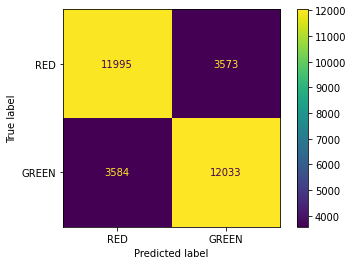


Model_1: Train: Classification Report
              precision    recall  f1-score   support

         RED       0.77      0.77      0.77     15568
       GREEN       0.77      0.77      0.77     15617

    accuracy                           0.77     31185
   macro avg       0.77      0.77      0.77     31185
weighted avg       0.77      0.77      0.77     31185

Model_1: Test: RMSE: 1.8016968111445986
Model_1: Test: MAPE: 0.0007999490991545787
Model_1: Test: R2: 0.9999980270440864


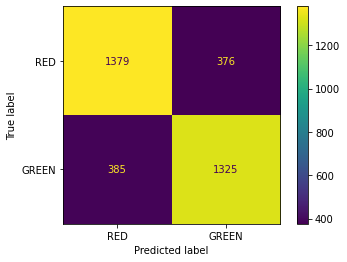


Model_1: Test: Classification Report
              precision    recall  f1-score   support

         RED       0.78      0.79      0.78      1755
       GREEN       0.78      0.77      0.78      1710

    accuracy                           0.78      3465
   macro avg       0.78      0.78      0.78      3465
weighted avg       0.78      0.78      0.78      3465



In [ ]:
#Prepare X - Y data
lagLength = 5

(dataX, dataY, dataSupport
, nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                        ,haDF_TATAMOTORS
                                        ,haDF_ASIANPAINTS
                                        ,haDF_SBI
                                        ,lagLength=lagLength, tgtColName='Close'
                                        )
#Split data
dataX, dataY, dataSupport, removedIndices = removeBadSamples([dataX, dataY, dataSupport])
train_dataX, test_dataX, train_dataY, test_dataY, train_dataSupport, test_dataSupport = train_test_split(dataX, dataY, dataSupport, test_size=0.10, random_state=42)

#Create model
model_1 = EMA(alpha=1.5)
# model_1 = DES(alpha=1.5, gamma=0.2)
# model_1 = TEMA(alpha=1)

# Evaluate model
publishModelScores(model_1, train_dataX, train_dataY, train_dataSupport[:,0], label='Model_1: Train')
publishModelScores(model_1, test_dataX, test_dataY, test_dataSupport[:,0], label='Model_1: Test')



# for alpha in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]:
#   model_1 = EMA(alpha=alpha)
#   printScoresOfAllConfig(model_1, train_dataX, train_dataY, train_dataSupport[:,0], label=f'EMA: alpha: {alpha}; lagLength: {lagLength}; dataSize: {len(train_dataX)};')

# for alpha in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]:
#   for gamma in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]:
#     model_1 = DES(alpha=alpha, gamma=gamma)
#     printScoresOfAllConfig(model_1, train_dataX, train_dataY, train_dataSupport[:,0], label=f'DES: alpha: {alpha}; gamma: {gamma}; lagLength: {lagLength}; dataSize: {len(train_dataX)};')

# for alpha in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]:
#   model_1 = TEMA(alpha=alpha)
#   printScoresOfAllConfig(model_1, train_dataX, train_dataY, train_dataSupport[:,0], label=f'TEMA: alpha: {alpha}; lagLength: {lagLength}; dataSize: {len(train_dataX)};')


Model 1: Effect of different lag lengths

In [ ]:
for lagLength in [2,3,4,5,6,7,8,10,12,14,20]:
  (dataX, dataY, dataSupport
  , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                          ,haDF_TATAMOTORS
                                          ,haDF_ASIANPAINTS
                                          ,haDF_SBI
                                          ,lagLength=lagLength, tgtColName='Close'
                                          )
  #Split data
  dataX, dataY, dataSupport, removedIndices = removeBadSamples([dataX, dataY, dataSupport])
  train_dataX, test_dataX, train_dataY, test_dataY, train_dataSupport, test_dataSupport = train_test_split(dataX, dataY, dataSupport, test_size=0.10, random_state=42)

  #Create model
  # model_1 = EMA(alpha=1.5)
  # model_1 = DES(alpha=1.5, gamma=0.2)
  model_1 = TEMA(alpha=0.5)

  printScoresOfAllConfig(model_1, train_dataX, train_dataY, train_dataSupport[:,0], label=f'TEMA: alpha: 0.5; lagLength: {lagLength}; dataSize: {len(train_dataX)};')

TEMA: alpha: 0.5; lagLength: 2; dataSize: 32521;: R2: 0.9999966369403468; MAPE: 0.0009879663751129776; RMSE: 2.3665944236098087;   F1: 0.7354533152909337; Precision GREEN: 0.7340987229862476; Precision RED: 0.7368939813959219;   Recall GREEN: 0.7368129159477447; Recall RED: 0.7341803228380286;
TEMA: alpha: 0.5; lagLength: 3; dataSize: 32076;: R2: 0.9999967903629561; MAPE: 0.0009748583809010442; RMSE: 2.3110837976777714;   F1: 0.727289684760306; Precision GREEN: 0.7264766163592323; Precision RED: 0.7265727699530516;   Recall GREEN: 0.7281045751633987; Recall RED: 0.7249391043657486;
TEMA: alpha: 0.5; lagLength: 4; dataSize: 31630;: R2: 0.9999968530851928; MAPE: 0.0009661043331330026; RMSE: 2.288809559002431;   F1: 0.7205882352941176; Precision GREEN: 0.7214533965244866; Precision RED: 0.7186966149952546;   Recall GREEN: 0.7197251465674841; Recall RED: 0.7204287435783598;
TEMA: alpha: 0.5; lagLength: 5; dataSize: 31185;: R2: 0.9999969442227088; MAPE: 0.0009536364574681656; RMSE: 2.257652

##Model 2: Using Moving Averages

###Price derivatives correlation

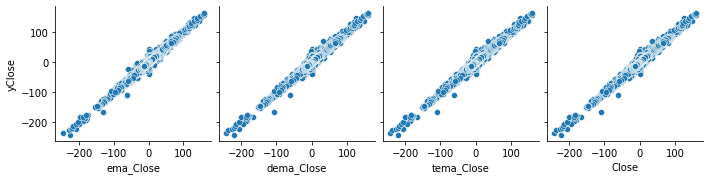

In [ ]:
ema_alpha=1.5
dema_alpha=0.8
tema_alpha=0.8


dim_TATAMOTORS = deriveExtraDimensions(baseShifted_TATAMOTORS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
dim_ASIANPAINTS = deriveExtraDimensions(baseShifted_ASIANPAINTS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
dim_SBI = deriveExtraDimensions(baseShifted_SBI, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)


(dataX, dataY, dataSupport
, nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingPriceDerivatives
                                        ,dim_TATAMOTORS
                                        ,dim_ASIANPAINTS
                                        ,dim_SBI
                                        ,tgtColName='Close'
                                        ,supColName=None
                                        ,upDownMultiplier=None
                                        # ,scalingFunc=applyMinMaxScalingXY
                                        # ,threshold=10
                                        ,removeUpDownValues=False
                                      )


data = pd.DataFrame(dataX, columns=['ema_Close' , 'dema_Close' , 'tema_Close', 'Close'])
data['yClose'] = dataY
sns.pairplot(data
            ,x_vars=['ema_Close' , 'dema_Close' , 'tema_Close', 'Close']
            ,y_vars=['yClose'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in double_scalars



Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  19.8s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  18.6s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  16.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  18.4s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  15.0s
***********************************************************************
Best configuration for this model: MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
             hidden_layer_sizes=(15,), max_iter=1000)
***********************************************************************
Model_2 MLP: Train: RMSE: 1.0963069176456914
Model_2 MLP: Train: MAPE: 0.00042203687179147233
Model_2 MLP: Train: R2: 0.999999282363354


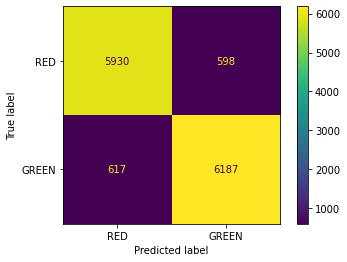


Model_2 MLP: Train: Classification Report
              precision    recall  f1-score   support

         RED       0.91      0.91      0.91      6528
       GREEN       0.91      0.91      0.91      6804

    accuracy                           0.91     13332
   macro avg       0.91      0.91      0.91     13332
weighted avg       0.91      0.91      0.91     13332

Model_2 MLP: Test: RMSE: 1.1976661717203552
Model_2 MLP: Test: MAPE: 0.0004246914906626171
Model_2 MLP: Test: R2: 0.9999991503273424


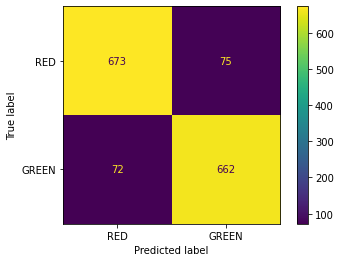


Model_2 MLP: Test: Classification Report
              precision    recall  f1-score   support

         RED       0.90      0.90      0.90       748
       GREEN       0.90      0.90      0.90       734

    accuracy                           0.90      1482
   macro avg       0.90      0.90      0.90      1482
weighted avg       0.90      0.90      0.90      1482



In [ ]:
#Derive dimensions
# ema_alpha=1.5
# dema_alpha=0.8
# tema_alpha=0.8
# upDownMultiplier=None

ema_alpha=1.3
dema_alpha=1.1
tema_alpha=1.1
upDownMultiplier=None

# dim_TATAMOTORS = deriveExtraDimensions(baseShifted_TATAMOTORS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
# dim_ASIANPAINTS = deriveExtraDimensions(baseShifted_ASIANPAINTS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
# dim_SBI = deriveExtraDimensions(baseShifted_SBI, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)


dim_TATAMOTORS = deriveExtraDimensions(haDF_TATAMOTORS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
dim_ASIANPAINTS = deriveExtraDimensions(haDF_ASIANPAINTS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
dim_SBI = deriveExtraDimensions(haDF_SBI, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)


#Prepare X - Y data
(dataX, dataY, dataSupport
, nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingPriceDerivatives
                                        ,dim_TATAMOTORS
                                        ,dim_ASIANPAINTS
                                        ,dim_SBI
                                        ,tgtColName='Close'
                                        ,supColName='ema_Close'
                                        ,upDownMultiplier=upDownMultiplier
                                        ,scalingFunc=applyZscoreScaling
                                        ,threshold=10
                                        ,removeUpDownValues=False
                                      )

#split train  - test
(train_dataX, test_dataX, train_dataY, test_dataY
, train_dataSupport, test_dataSupport
, train_nonScaled_dataX, test_nonScaled_dataX
, train_nonScaled_dataY, test_nonScaled_dataY
) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                      , test_size=0.10, random_state=42)

train_true_open = train_dataSupport[:,0]
train_true_close = train_dataSupport[:,1]
test_true_open = test_dataSupport[:,0]
test_true_close = test_dataSupport[:,1]

#Create model
# param_grid = {'loss': ['squared_epsilon_insensitive'], 'epsilon': [1e-10], 'C':[1] , 'dual': [False]}
# model_2 = createModelWithOptimalParam(LinearSVR(), param_grid, train_dataX, train_dataY)

param_grid = {'activation': ['tanh'], 'hidden_layer_sizes':[(15,)], 'batch_size':[1000], 'max_iter':[1000], 'alpha': [0.1]}
model_2 = createModelWithOptimalParam(MLPRegressor(), param_grid, train_dataX, train_dataY)

# from sklearn.ensemble import RandomForestRegressor
# # param_grid = {'criterion':['squared_error'], 'n_estimators':[100, 150, 200]}
# # param_grid = {'min_samples_split':[550,650]} #best configuration are default values itself
# param_grid = {}
# model_2 = createModelWithOptimalParam(RandomForestRegressor(), param_grid, train_dataX, train_dataY)


# model_2 = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
# model_2.fit(train_dataX, train_dataY)

#Evaluate model
publishModelScores(model_2, train_dataX, train_true_close, train_true_open
                   , label='Model_2 MLP: Train'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=train_nonScaled_dataX
                   )
publishModelScores(model_2, test_dataX, test_true_close, test_true_open
                   , label='Model_2 MLP: Test'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=test_nonScaled_dataX
                   )

Model 2: search best config; scaled; effect of ema

In [ ]:
# Search the best configuration for Model-2
ema_A = [1.3,1.5]
dema_A = np.arange(1,19,2) / 10
tema_A = np.arange(1,19,2) / 10
upDownMultiplier=None
threshold=10

np.seterr(all="ignore")
for ema_alpha in ema_A:
  for dema_alpha in dema_A:
    for tema_alpha in tema_A:   
      #  
      dim_TATAMOTORS = deriveExtraDimensions(haDF_TATAMOTORS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
      dim_ASIANPAINTS = deriveExtraDimensions(haDF_ASIANPAINTS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
      dim_SBI = deriveExtraDimensions(haDF_SBI, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
      

      # for upDownMultiplier in [-5,-4,-3,-2,-1,-0.5,-0.3,-0.2,-0.1]:
      (dataX, dataY, dataSupport
      , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingPriceDerivatives
                                              ,dim_TATAMOTORS
                                              ,dim_ASIANPAINTS
                                              ,dim_SBI
                                              ,tgtColName='Close'
                                              ,supColName=None
                                              ,upDownMultiplier=upDownMultiplier
                                              ,scalingFunc=applyMinMaxScalingXY
                                              ,threshold=threshold
                                              ,removeUpDownValues=False
                                            )
    
      #split train  - test
      (train_dataX, test_dataX, train_dataY, test_dataY
      , train_dataSupport, test_dataSupport
      , train_nonScaled_dataX, test_nonScaled_dataX
      , train_nonScaled_dataY, test_nonScaled_dataY
      ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                            , test_size=0.10, random_state=42)

      train_true_open = train_dataSupport[:,0]
      train_true_close = train_dataSupport[:,1]
      test_true_open = test_dataSupport[:,0]
      test_true_close = test_dataSupport[:,1]

      model_2_with_scaling = MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
                                          hidden_layer_sizes=(15,), max_iter=1000)
      # model_2_with_scaling = LinearSVR(loss='squared_epsilon_insensitive', epsilon=1e-5 , dual=False)
      model_2_with_scaling.fit(train_dataX, train_dataY)


      printScoresOfAllConfig(model_2_with_scaling, train_dataX, train_true_close, train_true_open
                      , label=f'model_2_with_scaling: data_size: {len(train_dataX)}; ema: {ema_alpha}; dema: {dema_alpha}; tema: {tema_alpha}; up-down: {upDownMultiplier}'
                      , inverseScaling=inverseZscoreScaling
                      , nonScaled_dataX=train_nonScaled_dataX
                  )



model_2_with_scaling: data_size: 32450; ema: 1.3; dema: 0.1; tema: 0.1; up-down: None: R2: 0.9999959042190637; MAPE: 0.001089018497927255; RMSE: 2.613251370842844;   F1: 0.7202305414551609; Precision GREEN: 0.6299310918928919; Precision RED: 0.7617068440011083;   Recall GREEN: 0.8407505709524103; Recall RED: 0.5075389254723368;
model_2_with_scaling: data_size: 32422; ema: 1.3; dema: 0.1; tema: 0.3; up-down: None: R2: 0.9999967342338463; MAPE: 0.0009730292185807921; RMSE: 2.3323140081382263;   F1: 0.7671868526446624; Precision GREEN: 0.6939142600179874; Precision RED: 0.8143939393939394;   Recall GREEN: 0.8577604842196281; Recall RED: 0.6225740866243608;
model_2_with_scaling: data_size: 32328; ema: 1.3; dema: 0.1; tema: 0.5; up-down: None: R2: 0.9999969405650142; MAPE: 0.0009510571886772685; RMSE: 2.2554485592462803;   F1: 0.7655150984435468; Precision GREEN: 0.7015273103805333; Precision RED: 0.8051179589641128;   Recall GREEN: 0.8423473828173567; Recall RED: 0.64505602758281;
model_2_

##Model 3: Using lag prices

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=   3.8s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=   6.4s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=   6.3s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=   3.5s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=   5.0s
***********************************************************************
Best configuration for this model: MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
             hidden_layer_sizes=(15,), max_iter=1000)
***********************************************************************
Model_3 MLP: Train: RMSE: 1.2980102770537325
Model_3 MLP: Train: MAPE: 0.00056

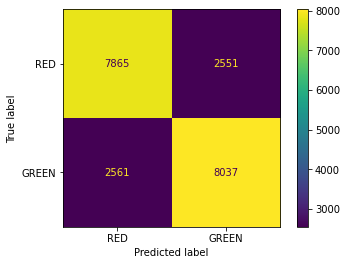


Model_3 MLP: Train: Classification Report
              precision    recall  f1-score   support

         RED       0.75      0.76      0.75     10416
       GREEN       0.76      0.76      0.76     10598

    accuracy                           0.76     21014
   macro avg       0.76      0.76      0.76     21014
weighted avg       0.76      0.76      0.76     21014

Model_3 MLP: Test: RMSE: 1.231945267364519
Model_3 MLP: Test: MAPE: 0.0005734139147998427
Model_3 MLP: Test: R2: 0.9999990892629


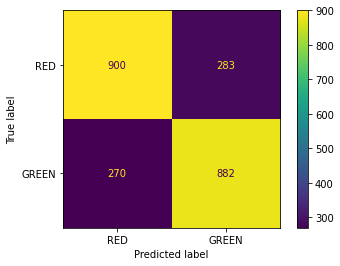


Model_3 MLP: Test: Classification Report
              precision    recall  f1-score   support

         RED       0.77      0.76      0.76      1183
       GREEN       0.76      0.77      0.76      1152

    accuracy                           0.76      2335
   macro avg       0.76      0.76      0.76      2335
weighted avg       0.76      0.76      0.76      2335



In [ ]:
#Prepare X - Y data
lagLength = 3

(dataX, dataY, dataSupport
 , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                          ,haDF_TATAMOTORS
                                          ,haDF_ASIANPAINTS
                                          ,haDF_SBI
                                          ,lagLength=lagLength, tgtColName='Close'
                                          ,supColName=None
                                          ,upDownMultiplier=0.5
                                          ,scalingFunc=applyZscoreScaling
                                          ,threshold=3
                                          ,removeUpDownValues=True
                                         )

# #using base shift
# (dataX, dataY, dataSupport
#  , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
#                                           ,baseShifted_TATAMOTORS
#                                           ,baseShifted_ASIANPAINTS
#                                           ,baseShifted_SBI
#                                           ,lagLength=lagLength, tgtColName='Close'
#                                           ,supColName='baseRestorer'
#                                           ,upDownMultiplier=1.5
#                                           ,scalingFunc=applyZscoreScaling
#                                           ,threshold=3
#                                           ,removeUpDownValues=True
#                                          )


#split train  - test
(train_dataX, test_dataX, train_dataY, test_dataY
 , train_dataSupport, test_dataSupport
 , train_nonScaled_dataX, test_nonScaled_dataX
 , train_nonScaled_dataY, test_nonScaled_dataY
 ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                      , test_size=0.10, random_state=42)

train_true_open = train_dataSupport[:,0]
train_true_close = train_dataSupport[:,1]
test_true_open = test_dataSupport[:,0]
test_true_close = test_dataSupport[:,1]
# train_baseRestorer = train_dataSupport[:,2]
# test_baseRestorer = test_dataSupport[:,2]

#Create model
# param_grid = {'C': [10,20], 'gamma': [1e-2] ,'kernel': ['rbf']}
# param_grid = {'epsilon': [0.1], 'C': [1], 'gamma':[0.1]}
# model_3 = createModelWithOptimalParam(SVR(), param_grid, train_dataX, train_dataY)

param_grid = {'activation': ['tanh'], 'hidden_layer_sizes':[(15,)], 'batch_size':[1000], 'max_iter':[1000], 'alpha': [0.1]}
model_3_mlp = createModelWithOptimalParam(MLPRegressor(), param_grid, train_dataX, train_dataY)


#Evaluate model
publishModelScores(model_3_mlp, train_dataX, train_true_close, train_true_open
                   , label='Model_3 MLP: Train'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=train_nonScaled_dataX
                  #  , restoreBase=True , baseRestorer=train_baseRestorer 
                   )
publishModelScores(model_3_mlp, test_dataX, test_true_close, test_true_open
                   , label='Model_3 MLP: Test'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=test_nonScaled_dataX
                  #  , restoreBase=True , baseRestorer=test_baseRestorer 
                   )



Model 3: Search best configuration: With scaling

In [ ]:
np.seterr(all="ignore")
for lagLength in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
  (dataX, dataY, dataSupport
 , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                          ,haDF_TATAMOTORS
                                          ,haDF_ASIANPAINTS
                                          ,haDF_SBI
                                          ,lagLength=lagLength, tgtColName='Close'
                                          ,supColName=None
                                          ,upDownMultiplier=1.5
                                          ,scalingFunc=applyMinMaxScalingXY
                                          ,threshold=3
                                          ,removeUpDownValues=True
                                         )
 
  #split train  - test
  (train_dataX, test_dataX, train_dataY, test_dataY
  , train_dataSupport, test_dataSupport
  , train_nonScaled_dataX, test_nonScaled_dataX
  , train_nonScaled_dataY, test_nonScaled_dataY
  ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                        , test_size=0.10, random_state=42)

  train_true_open = train_dataSupport[:,0]
  train_true_close = train_dataSupport[:,1]
  test_true_open = test_dataSupport[:,0]
  test_true_close = test_dataSupport[:,1]

  model_3_with_scaling = MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
                                      hidden_layer_sizes=(15,), max_iter=1000)
  model_3_with_scaling.fit(train_dataX, train_dataY)


  printScoresOfAllConfig(model_3_with_scaling, train_dataX, train_true_close, train_true_open
                   , label=f'model_3_with_scaling: data_size: {len(train_dataX)}; '
                   , inverseScaling=inverseMinMaxScalingXY
                   , nonScaled_dataX=train_nonScaled_dataX
              )


model_3_with_scaling: data_size: 30653; : R2: 0.999997862351341; MAPE: 0.0008182375446288914; RMSE: 1.8865381638638026;   F1: 0.7614163454628601; Precision GREEN: 0.7625621565035331; Precision RED: 0.7608822955299629;   Recall GREEN: 0.7602739726027398; Recall RED: 0.7631664817594466;
model_3_with_scaling: data_size: 30667; : R2: 0.9999979993267751; MAPE: 0.0007911735598068818; RMSE: 1.8258576275848546;   F1: 0.7646520146520146; Precision GREEN: 0.7668590921018106; Precision RED: 0.7638591713674382;   Recall GREEN: 0.7624576050091312; Recall RED: 0.7682425823280078;
model_3_with_scaling: data_size: 30681; : R2: 0.9999979941751252; MAPE: 0.000788203646034545; RMSE: 1.8282146380146262;   F1: 0.7677879449021459; Precision GREEN: 0.7675629923823165; Precision RED: 0.7675890875864769;   Recall GREEN: 0.7680130293159609; Recall RED: 0.7671384775944166;
model_3_with_scaling: data_size: 30687; : R2: 0.9999980025621056; MAPE: 0.0007880317648900739; RMSE: 1.8230416400130687;   F1: 0.767428926620

Model 3: search best config: effect of up-down multiplier

In [ ]:
np.seterr(all="ignore")
for upDownMultiplier in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
  lagLength=5
  (dataX, dataY, dataSupport
 , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                          ,haDF_TATAMOTORS
                                          ,haDF_ASIANPAINTS
                                          ,haDF_SBI
                                          ,lagLength=lagLength, tgtColName='Close'
                                          ,supColName=None
                                          ,upDownMultiplier=upDownMultiplier
                                          ,scalingFunc=applyZscoreScaling
                                          ,threshold=3
                                          ,removeUpDownValues=True
                                         )
 
  #split train  - test
  (train_dataX, test_dataX, train_dataY, test_dataY
  , train_dataSupport, test_dataSupport
  , train_nonScaled_dataX, test_nonScaled_dataX
  , train_nonScaled_dataY, test_nonScaled_dataY
  ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                        , test_size=0.10, random_state=42)

  train_true_open = train_dataSupport[:,0]
  train_true_close = train_dataSupport[:,1]
  test_true_open = test_dataSupport[:,0]
  test_true_close = test_dataSupport[:,1]

  model_3_with_scaling = MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
                                      hidden_layer_sizes=(15,), max_iter=1000)
  model_3_with_scaling.fit(train_dataX, train_dataY)


  printScoresOfAllConfig(model_3_with_scaling, train_dataX, train_true_close, train_true_open
                   , label=f'model_3_with_scaling: data_size: {len(train_dataX)}; up-down: {upDownMultiplier};'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=train_nonScaled_dataX
              )


model_3_with_scaling: data_size: 22835; up-down: 0.1;: R2: 0.9999988135451855; MAPE: 0.000618144691665468; RMSE: 1.4082246625602566;   F1: 0.7405543747017742; Precision GREEN: 0.7378976486860305; Precision RED: 0.7382621815922605;   Recall GREEN: 0.7432303003918154; Recall RED: 0.732863436123348;
model_3_with_scaling: data_size: 23392; up-down: 0.2;: R2: 0.9999988069867712; MAPE: 0.0006206520938059204; RMSE: 1.4103980364953534;   F1: 0.7394213150381387; Precision GREEN: 0.7408419434719494; Precision RED: 0.7363239448677339;   Recall GREEN: 0.7380061245321538; Recall RED: 0.739171536610519;
model_3_with_scaling: data_size: 23868; up-down: 0.3;: R2: 0.9999988207309674; MAPE: 0.0006256907762574321; RMSE: 1.403589294261917;   F1: 0.7421010893609916; Precision GREEN: 0.7436219155165202; Precision RED: 0.7386048854192898;   Recall GREEN: 0.7405864711762746; Recall RED: 0.7416554281861092;
model_3_with_scaling: data_size: 24298; up-down: 0.4;: R2: 0.99999876522913; MAPE: 0.0006354018352881959

Model 3: seach best config: without scaling; using shifted base

In [ ]:
np.seterr(all="ignore")
for lagLength in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
  #using base shift
  (dataX, dataY, dataSupport
  , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                            ,baseShifted_TATAMOTORS
                                            ,baseShifted_ASIANPAINTS
                                            ,baseShifted_SBI
                                            ,lagLength=lagLength, tgtColName='Close'
                                            ,supColName='baseRestorer'
                                            ,upDownMultiplier=1.5
                                            ,removeUpDownValues=True
                                          )
 
  #split train  - test
  (train_dataX, test_dataX, train_dataY, test_dataY
  , train_dataSupport, test_dataSupport
  , train_nonScaled_dataX, test_nonScaled_dataX
  , train_nonScaled_dataY, test_nonScaled_dataY
  ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                        , test_size=0.10, random_state=42)

  train_true_open = train_dataSupport[:,0]
  train_true_close = train_dataSupport[:,1]
  test_true_open = test_dataSupport[:,0]
  test_true_close = test_dataSupport[:,1]
  train_baseRestorer = train_dataSupport[:,2]
  test_baseRestorer = test_dataSupport[:,2]

  model_3_with_shiftbase = MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
                                      hidden_layer_sizes=(15,), max_iter=1000)
  model_3_with_shiftbase.fit(train_dataX, train_dataY)


  printScoresOfAllConfig(model_3_with_shiftbase, train_dataX, train_true_close, train_true_open
                   , label=f'model_3_with_shiftbase: No scaling: data_size: {len(train_dataX)}; '
                  , restoreBase=True , baseRestorer=train_baseRestorer 
              )

model_3_with_shiftbase: No scaling: data_size: 30739; : R2: 0.9999974261728203; MAPE: 0.0008267289327585327; RMSE: 2.0700581618681313;   F1: 0.7614082512711591; Precision GREEN: 0.7538873311241396; Precision RED: 0.7639396557453313;   Recall GREEN: 0.7690807437264335; Recall RED: 0.7485185908706128;
model_3_with_shiftbase: No scaling: data_size: 30739; : R2: 0.9999972372173778; MAPE: 0.0008260558201466846; RMSE: 2.144698333585307;   F1: 0.7637205761055771; Precision GREEN: 0.7457868649318463; Precision RED: 0.7708747174464005;   Recall GREEN: 0.7825380314653491; Recall RED: 0.7328254216318292;
model_3_with_shiftbase: No scaling: data_size: 30739; : R2: 0.9999973476781467; MAPE: 0.0008066067207412452; RMSE: 2.101386647254547;   F1: 0.771107299409186; Precision GREEN: 0.7539130434782608; Precision RED: 0.7784001639456247;   Recall GREEN: 0.7891041477051098; Recall RED: 0.7420069023897897;
model_3_with_shiftbase: No scaling: data_size: 30739; : R2: 0.9999969185259078; MAPE: 0.000834428990

##Model 4: Using lag prices; EMA 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=tanh, alpha=1e-07, batch_size=1000, hidden_layer_sizes=(15,), max_iter=400; total time=   5.4s
[CV] END activation=tanh, alpha=1e-07, batch_size=1000, hidden_layer_sizes=(15,), max_iter=400; total time=   5.5s
[CV] END activation=tanh, alpha=1e-07, batch_size=1000, hidden_layer_sizes=(15,), max_iter=400; total time=   5.8s
[CV] END activation=tanh, alpha=1e-07, batch_size=1000, hidden_layer_sizes=(15,), max_iter=400; total time=   4.2s
[CV] END activation=tanh, alpha=1e-07, batch_size=1000, hidden_layer_sizes=(15,), max_iter=400; total time=   5.8s
***********************************************************************
Best configuration for this model: MLPRegressor(activation='tanh', alpha=1e-07, batch_size=1000,
             hidden_layer_sizes=(15,), max_iter=400)
***********************************************************************
Model 4 MLP: Train: RMSE: 1.7983079965505804
Model 4 MLP: Train: MAPE: 0

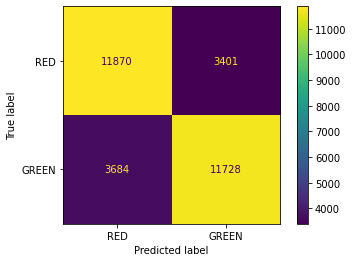


Model 4 MLP: Train: Classification Report
              precision    recall  f1-score   support

         RED       0.76      0.78      0.77     15271
       GREEN       0.78      0.76      0.77     15412

    accuracy                           0.77     30683
   macro avg       0.77      0.77      0.77     30683
weighted avg       0.77      0.77      0.77     30683

Model 4 MLP: Test: RMSE: 1.9844331509432331
Model 4 MLP: Test: MAPE: 0.000788016259597964
Model 4 MLP: Test: R2: 0.9999976473611617


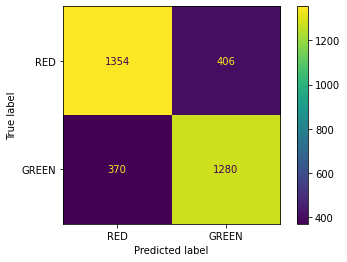


Model 4 MLP: Test: Classification Report
              precision    recall  f1-score   support

         RED       0.79      0.77      0.78      1760
       GREEN       0.76      0.78      0.77      1650

    accuracy                           0.77      3410
   macro avg       0.77      0.77      0.77      3410
weighted avg       0.77      0.77      0.77      3410



In [ ]:
upDownMultiplier=1.5
ema_alpha=0.5

dim_TATAMOTORS = deriveExtraDimensions(haDF_TATAMOTORS, ema_alpha=ema_alpha)
dim_ASIANPAINTS = deriveExtraDimensions(haDF_ASIANPAINTS, ema_alpha=ema_alpha)
dim_SBI = deriveExtraDimensions(haDF_SBI, ema_alpha=ema_alpha)

lagLength = 5
(dataX, dataY, dataSupport
, nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                        ,dim_TATAMOTORS
                                        ,dim_ASIANPAINTS
                                        ,dim_SBI
                                        ,lagLength=lagLength, tgtColName='ema_Close'
                                        ,supColName='ema_Close'
                                        ,upDownMultiplier=upDownMultiplier
                                        ,scalingFunc=applyZscoreScaling
                                        ,threshold=10
                                        ,removeUpDownValues=True
                                        )

#split train  - test
(train_dataX, test_dataX, train_dataY, test_dataY
, train_dataSupport, test_dataSupport
, train_nonScaled_dataX, test_nonScaled_dataX
, train_nonScaled_dataY, test_nonScaled_dataY
) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                      , test_size=0.10, random_state=42)

train_true_open = train_dataSupport[:,0]
train_true_close = train_dataSupport[:,1]
test_true_open = test_dataSupport[:,0]
test_true_close = test_dataSupport[:,1]

train_true_ema = train_nonScaled_dataY
test_true_ema = test_nonScaled_dataY

#Create model
# param_grid = {'C': [10,20], 'gamma': [1e-2] ,'kernel': ['rbf']}
# param_grid = {'epsilon': [0.1], 'C': [1], 'gamma':[0.1]}
# model_3 = createModelWithOptimalParam(SVR(), param_grid, train_dataX, train_dataY)

param_grid = {'activation': ['tanh'], 'hidden_layer_sizes':[(15,)], 'batch_size':[1000], 'max_iter':[400], 'alpha': [1e-7]}
model_4_mlp = createModelWithOptimalParam(MLPRegressor(), param_grid, train_dataX, train_dataY)



#Evaluate model
publishModelScores(model_4_mlp, train_dataX, train_true_close, train_true_open
                   , label='Model 4 MLP: Train'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=train_nonScaled_dataX
                   , ema_alpha = ema_alpha
                   , previous_EMA = train_dataSupport[:,2]
                   
                   )
publishModelScores(model_4_mlp, test_dataX, test_true_close, test_true_open
                   , label='Model 4 MLP: Test'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=test_nonScaled_dataX
                   , ema_alpha = ema_alpha
                   , previous_EMA = test_dataSupport[:,2]                  
                   )



In [ ]:
#Search the best configuration for Model-4
# alpha_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
alpha_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1]
for ema_alpha in alpha_values:
  #Prepare X - Y data
  ema_alpha=ema_alpha
  dema_alpha=0.1
  tema_alpha=0.1

  dim_TATAMOTORS = deriveExtraDimensions(haDF_TATAMOTORS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
  dim_ASIANPAINTS = deriveExtraDimensions(haDF_ASIANPAINTS, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)
  dim_SBI = deriveExtraDimensions(haDF_SBI, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)

  lagLength = 3
  dataX_TATAMOTORS, dataY_TATAMOTORS, dataSupport_TATAMOTORS = createDataXY_usingLagPricesEMA(dim_TATAMOTORS, lagLength=lagLength)
  dataX_ASIANPAINTS, dataY_ASIANPAINTS, dataSupport_ASIANPAINTS = createDataXY_usingLagPricesEMA(dim_ASIANPAINTS, lagLength=lagLength)
  dataX_SBI, dataY_SBI, dataSupport_SBI = createDataXY_usingLagPricesEMA(dim_SBI, lagLength=lagLength)

  dataX = np.array(joinMultipleDataLists([dataX_TATAMOTORS,dataX_ASIANPAINTS,dataX_SBI]))
  dataY = np.array(joinMultipleDataLists([dataY_TATAMOTORS,dataY_ASIANPAINTS,dataY_SBI]))
  dataSupport = np.array(joinMultipleDataLists([dataSupport_TATAMOTORS,dataSupport_ASIANPAINTS,dataSupport_SBI]))

  #Pre-Clean data 
  dataX, dataY, dataSupport, removedIndices = removeBadSamples([dataX, dataY, dataSupport])

  #apply necessary scaling function
  nonScaled_dataX = dataX
  nonScaled_dataY = dataY
  dataX, dataY = applyZscoreScaling(dataX, dataY)
  dataX, dataY, removedIndices = removeBadSamples([dataX, dataY], threshold=3)
  dataSupport, nonScaled_dataX, nonScaled_dataY, removedIndices = removeBadSamples([dataSupport, nonScaled_dataX, nonScaled_dataY], removeIndices=removedIndices)

  #split train  - test
  (train_dataX, test_dataX, train_dataY, test_dataY
  , train_dataSupport, test_dataSupport
  , train_nonScaled_dataX, test_nonScaled_dataX
  , train_nonScaled_dataY, test_nonScaled_dataY
  ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY, test_size=0.10, random_state=42)

  #remove up_Close and down_Close from features
  train_dataX = train_dataX[:,0:-2]
  test_dataX = test_dataX[:,0:-2]

  #Create model
  param_grid = {'activation': ['tanh'], 'hidden_layer_sizes':[(15,)], 'batch_size':[1000], 'max_iter':[400], 'alpha': [1e-7]}
  model_4 = GridSearchCV(MLPRegressor(), param_grid,refit=True,verbose=0)
  model_4.fit(train_dataX, train_dataY)

  train_true_open = train_dataSupport[:,0]
  train_true_close = train_dataSupport[:,1]
  test_true_open = test_dataSupport[:,0]
  test_true_close = test_dataSupport[:,1]

  train_true_ema = train_nonScaled_dataY
  test_true_ema = test_nonScaled_dataY

  printScoresOfAllConfig(model_4, train_dataX, train_true_close, train_true_open
                    , label=f'Model_4: data_size: {len(train_dataX)}; ema_alpha: {ema_alpha};'
                    , inverseScaling=inverseZscoreScaling
                    , nonScaled_dataX=train_nonScaled_dataX
                    , ema_alpha = ema_alpha
                    , previous_EMA = train_dataSupport[:,2]
                    )


Model_4: data_size: 28892; ema_alpha: 0.1;: R2: 0.9999913045926587; MAPE: 0.0016042512690467145; RMSE: 3.80031575948584;   F1: 0.47504422323193785; Precision GREEN: 0.47767857142857145; Precision RED: 0.47464962901896124;   Recall GREEN: 0.4724387719903415; Recall RED: 0.4798916440925193;
Model_4: data_size: 28346; ema_alpha: 0.2;: R2: 0.9999952053238333; MAPE: 0.0011739331924325517; RMSE: 2.82362917111384;   F1: 0.5117013438124978; Precision GREEN: 0.5125825952481372; Precision RED: 0.5054532577903683;   Recall GREEN: 0.5108231173380035; Recall RED: 0.5072134176675431;
Model_4: data_size: 28210; ema_alpha: 0.3;: R2: 0.9999965529531573; MAPE: 0.0010053250128813215; RMSE: 2.397052592089212;   F1: 0.6238807035068318; Precision GREEN: 0.6301527817814933; Precision RED: 0.6225059299567463;   Recall GREEN: 0.617732250088308; Recall RED: 0.6348630380647456;
Model_4: data_size: 28107; ema_alpha: 0.4;: R2: 0.999997127179024; MAPE: 0.0009141079050956914; RMSE: 2.185572559838202;   F1: 0.7276356

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in double_scalars



Model_4: data_size: 28429; ema_alpha: 1;: R2: 0.9999983490221126; MAPE: 0.0007362094259061825; RMSE: 1.6540749651821256;   F1: 0.7608262556359442; Precision GREEN: 0.7597905759162303; Precision RED: 0.7587918321043675;   Recall GREEN: 0.7618647627047459; Recall RED: 0.7566994272785124;
Model_4: data_size: 28512; ema_alpha: 1.1;: R2: 0.9999984063132784; MAPE: 0.0007268244614600539; RMSE: 1.6263543786158452;   F1: 0.764390243902439; Precision GREEN: 0.7609434616718695; Precision RED: 0.7647726466624104;   Recall GREEN: 0.767868393419671; Recall RED: 0.7577844942714557;


Model 4.2: WMA lag prices

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  26.3s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  24.1s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  22.3s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  19.8s
[CV] END activation=tanh, alpha=0.1, batch_size=1000, hidden_layer_sizes=(15,), max_iter=1000; total time=  19.5s
***********************************************************************
Best configuration for this model: MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
             hidden_layer_sizes=(15,), max_iter=1000)
***********************************************************************
Model_4 WMA MLP: Train: RMSE: 2.453496362638867
Model_4 WMA MLP: Train: MAPE: 

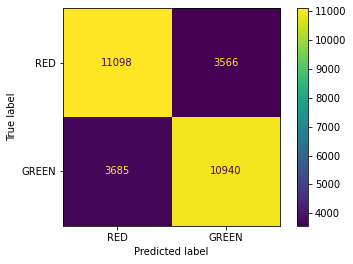


Model_4 WMA MLP: Train: Classification Report
              precision    recall  f1-score   support

         RED       0.75      0.76      0.75     14664
       GREEN       0.75      0.75      0.75     14625

    accuracy                           0.75     29289
   macro avg       0.75      0.75      0.75     29289
weighted avg       0.75      0.75      0.75     29289

Model_4 WMA MLP: Test: RMSE: 2.437924751476618
Model_4 WMA MLP: Test: MAPE: 0.0010798026686287367
Model_4 WMA MLP: Test: R2: 0.9999964035894708


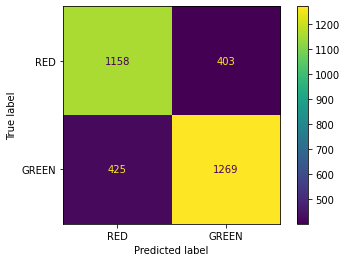


Model_4 WMA MLP: Test: Classification Report
              precision    recall  f1-score   support

         RED       0.73      0.74      0.74      1561
       GREEN       0.76      0.75      0.75      1694

    accuracy                           0.75      3255
   macro avg       0.75      0.75      0.75      3255
weighted avg       0.75      0.75      0.75      3255



In [ ]:
#Prepare X - Y data
wma_span=3
upDownMultiplier=0.5

dim_TATAMOTORS = deriveExtraDimensions(haDF_TATAMOTORS, wma_span=wma_span)
dim_ASIANPAINTS = deriveExtraDimensions(haDF_ASIANPAINTS, wma_span=wma_span)
dim_SBI = deriveExtraDimensions(haDF_SBI, wma_span=wma_span)

lagLength = 3
(dataX, dataY, dataSupport
, nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                        ,dim_TATAMOTORS
                                        ,dim_ASIANPAINTS
                                        ,dim_SBI
                                        ,lagLength=lagLength, tgtColName='wma_Close'
                                        ,supColName='partial_wma_Close'
                                        ,upDownMultiplier=upDownMultiplier
                                        ,scalingFunc=applyZscoreScaling
                                        ,threshold=10
                                        ,removeUpDownValues=True
                                        )
 
#split train  - test
(train_dataX, test_dataX, train_dataY, test_dataY
, train_dataSupport, test_dataSupport
, train_nonScaled_dataX, test_nonScaled_dataX
, train_nonScaled_dataY, test_nonScaled_dataY
) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                      , test_size=0.10, random_state=42)

train_true_open = train_dataSupport[:,0]
train_true_close = train_dataSupport[:,1]
test_true_open = test_dataSupport[:,0]
test_true_close = test_dataSupport[:,1]

param_grid = {'activation': ['tanh'], 'hidden_layer_sizes':[(15,)], 'batch_size':[1000], 'max_iter':[1000], 'alpha': [0.1]}
model_4_wma = createModelWithOptimalParam(MLPRegressor(), param_grid, train_dataX, train_dataY)


#Evaluate model
publishModelScores(model_4_wma, train_dataX, train_true_close, train_true_open
                   , label='Model_4 WMA MLP: Train'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=train_nonScaled_dataX
                   , wma_span = wma_span
                   , partial_wma = train_dataSupport[:,2]   
                   )
publishModelScores(model_4_wma, test_dataX, test_true_close, test_true_open
                   , label='Model_4 WMA MLP: Test'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=test_nonScaled_dataX
                   , wma_span = wma_span
                   , partial_wma = test_dataSupport[:,2]   
                   )


In [ ]:
np.seterr(all="ignore")
for wma_span in [2,3,4,5,6,7,8,9,10]:
  upDownMultiplier=1.5

  dim_TATAMOTORS = deriveExtraDimensions(haDF_TATAMOTORS, wma_span=wma_span)
  dim_ASIANPAINTS = deriveExtraDimensions(haDF_ASIANPAINTS, wma_span=wma_span)
  dim_SBI = deriveExtraDimensions(haDF_SBI, wma_span=wma_span)

  lagLength = 5
  (dataX, dataY, dataSupport
  , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                          ,dim_TATAMOTORS
                                          ,dim_ASIANPAINTS
                                          ,dim_SBI
                                          ,lagLength=lagLength, tgtColName='wma_Close'
                                          ,supColName='partial_wma_Close'
                                          ,upDownMultiplier=upDownMultiplier
                                          ,scalingFunc=applyZscoreScaling
                                          ,threshold=10
                                          ,removeUpDownValues=True
                                          )
  
  #split train  - test
  (train_dataX, test_dataX, train_dataY, test_dataY
  , train_dataSupport, test_dataSupport
  , train_nonScaled_dataX, test_nonScaled_dataX
  , train_nonScaled_dataY, test_nonScaled_dataY
  ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                        , test_size=0.10, random_state=42)

  train_true_open = train_dataSupport[:,0]
  train_true_close = train_dataSupport[:,1]
  test_true_open = test_dataSupport[:,0]
  test_true_close = test_dataSupport[:,1]

  model_4_wma = MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
                                      hidden_layer_sizes=(15,), max_iter=1000)
  model_4_wma.fit(train_dataX, train_dataY)

  wma_prediction = model_4_wma.predict(train_dataX)
  wma_prediction = inverseZscoreScaling(train_nonScaled_dataX, wma_prediction)
  wma_rmse = mean_squared_error(train_nonScaled_dataY, wma_prediction, squared=False)

  printScoresOfAllConfig(model_4_wma, train_dataX, train_true_close, train_true_open
                   , label=f'model_4_wma: data_size: {len(train_dataX)}; wma_rmse: {wma_rmse};'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=train_nonScaled_dataX
                   , wma_span = wma_span
                   , partial_wma = train_dataSupport[:,2]   
              )

model_4_wma: data_size: 30231; wma_rmse: 1.1948198116333892;: R2: 0.9999975797842751; MAPE: 0.0008953805734344827; RMSE: 2.006672643437672;   F1: 0.7626061571125266; Precision GREEN: 0.7665732959850607; Precision RED: 0.7600577541510796;   Recall GREEN: 0.7586798679867987; Recall RED: 0.7679198992109276;
model_4_wma: data_size: 29795; wma_rmse: 0.8941917263898671;: R2: 0.999996123265546; MAPE: 0.0011096313146056296; RMSE: 2.541358533307492;   F1: 0.7666489078316463; Precision GREEN: 0.7645105591712047; Precision RED: 0.7650810884169098;   Recall GREEN: 0.768799252036864; Recall RED: 0.7607448890088389;
model_4_wma: data_size: 29352; wma_rmse: 0.7206890629194599;: R2: 0.9999945211239569; MAPE: 0.0013036198436649897; RMSE: 3.0200391753961213;   F1: 0.7594893617021277; Precision GREEN: 0.7614334470989761; Precision RED: 0.7571758944361311;   Recall GREEN: 0.7575551782682513; Recall RED: 0.7610583168113763;
model_4_wma: data_size: 28918; wma_rmse: 0.6014540292256213;: R2: 0.999993519939121

In [ ]:
np.seterr(all="ignore")
for sma_span in [2,3,4,5,6,7,8,9,10]:
  upDownMultiplier=1.5

  dim_TATAMOTORS = deriveExtraDimensions(haDF_TATAMOTORS, sma_span=sma_span)
  dim_ASIANPAINTS = deriveExtraDimensions(haDF_ASIANPAINTS, sma_span=sma_span)
  dim_SBI = deriveExtraDimensions(haDF_SBI, sma_span=sma_span)

  lagLength = 5
  (dataX, dataY, dataSupport
  , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                          ,dim_TATAMOTORS
                                          ,dim_ASIANPAINTS
                                          ,dim_SBI
                                          ,lagLength=lagLength, tgtColName='sma_Close'
                                          ,supColName='partial_sma_Close'
                                          ,upDownMultiplier=upDownMultiplier
                                          ,scalingFunc=applyZscoreScaling
                                          ,threshold=10
                                          ,removeUpDownValues=True
                                          )
  
  #split train  - test
  (train_dataX, test_dataX, train_dataY, test_dataY
  , train_dataSupport, test_dataSupport
  , train_nonScaled_dataX, test_nonScaled_dataX
  , train_nonScaled_dataY, test_nonScaled_dataY
  ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                        , test_size=0.10, random_state=42)

  train_true_open = train_dataSupport[:,0]
  train_true_close = train_dataSupport[:,1]
  test_true_open = test_dataSupport[:,0]
  test_true_close = test_dataSupport[:,1]

  model_4_sma = MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
                                      hidden_layer_sizes=(15,), max_iter=1000)
  model_4_sma.fit(train_dataX, train_dataY)

  sma_prediction = model_4_sma.predict(train_dataX)
  sma_prediction = inverseZscoreScaling(train_nonScaled_dataX, sma_prediction)
  sma_rmse = mean_squared_error(train_nonScaled_dataY, sma_prediction, squared=False)

  printScoresOfAllConfig(model_4_sma, train_dataX, train_true_close, train_true_open
                   , label=f'model_4_sma: data_size: {len(train_dataX)}; sma_rmse: {sma_rmse};'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=train_nonScaled_dataX
                   , sma_span = sma_span
                   , partial_sma = train_dataSupport[:,2]   
              )

model_4_sma: data_size: 30244; sma_rmse: 1.0550219663444191;: R2: 0.9999953794613843; MAPE: 0.0012173505361668473; RMSE: 2.773241519142428;   F1: 0.7446413166102593; Precision GREEN: 0.74726957911561; Precision RED: 0.7438271604938271;   Recall GREEN: 0.7420314773178152; Recall RED: 0.7490411321253803;
model_4_sma: data_size: 29810; sma_rmse: 0.7021779734792283;: R2: 0.9999909123379772; MAPE: 0.0016725738938209438; RMSE: 3.8896373059922773;   F1: 0.7342748834244691; Precision GREEN: 0.7369696969696969; Precision RED: 0.7316176470588235;   Recall GREEN: 0.7315997058626914; Recall RED: 0.7369874082553364;
model_4_sma: data_size: 29380; sma_rmse: 0.5906303557550181;: R2: 0.9999862861850213; MAPE: 0.002040235610209574; RMSE: 4.780365412078856;   F1: 0.7141344807567531; Precision GREEN: 0.7185266630016492; Precision RED: 0.7116940922578905;   Recall GREEN: 0.7097956689973525; Recall RED: 0.7203904703392723;
model_4_sma: data_size: 28940; sma_rmse: 0.4628475056145803;: R2: 0.9999823748465797

In [ ]:
np.seterr(all="ignore")
for ema_alpha in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]:
  upDownMultiplier=1.5

  dim_TATAMOTORS = deriveExtraDimensions(haDF_TATAMOTORS, ema_alpha=ema_alpha)
  dim_ASIANPAINTS = deriveExtraDimensions(haDF_ASIANPAINTS, ema_alpha=ema_alpha)
  dim_SBI = deriveExtraDimensions(haDF_SBI, ema_alpha=ema_alpha)

  lagLength = 5
  (dataX, dataY, dataSupport
  , nonScaled_dataX, nonScaled_dataY) = prepareXYdata(createDataXY_usingLagPrices
                                          ,dim_TATAMOTORS
                                          ,dim_ASIANPAINTS
                                          ,dim_SBI
                                          ,lagLength=lagLength, tgtColName='ema_Close'
                                          ,supColName='ema_Close'
                                          ,upDownMultiplier=upDownMultiplier
                                          ,scalingFunc=applyZscoreScaling
                                          ,threshold=10
                                          ,removeUpDownValues=True
                                          )
  
  #split train  - test
  (train_dataX, test_dataX, train_dataY, test_dataY
  , train_dataSupport, test_dataSupport
  , train_nonScaled_dataX, test_nonScaled_dataX
  , train_nonScaled_dataY, test_nonScaled_dataY
  ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY
                        , test_size=0.10, random_state=42)

  train_true_open = train_dataSupport[:,0]
  train_true_close = train_dataSupport[:,1]
  test_true_open = test_dataSupport[:,0]
  test_true_close = test_dataSupport[:,1]

  model_4_ema = MLPRegressor(activation='tanh', alpha=0.1, batch_size=1000,
                                      hidden_layer_sizes=(15,), max_iter=1000)
  model_4_ema.fit(train_dataX, train_dataY)

  ema_prediction = model_4_ema.predict(train_dataX)
  ema_prediction = inverseZscoreScaling(train_nonScaled_dataX, ema_prediction)
  ema_rmse = mean_squared_error(train_nonScaled_dataY, ema_prediction, squared=False)

  printScoresOfAllConfig(model_4_ema, train_dataX, train_true_close, train_true_open
                   , label=f'model_4_ema: data_size: {len(train_dataX)}; ema_rmse: {ema_rmse};'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=train_nonScaled_dataX
                   , ema_alpha=ema_alpha
                   , previous_EMA = train_dataSupport[:,2]   
              )

model_4_ema: data_size: 30725; ema_rmse: 0.18290593075591788;: R2: 0.9999979918538504; MAPE: 0.0007899982628331468; RMSE: 1.829059307559176;   F1: 0.7667121418826738; Precision GREEN: 0.7661148977604674; Precision RED: 0.7663838120104438;   Recall GREEN: 0.7673103179247123; Recall RED: 0.7651850886339937;
model_4_ema: data_size: 30709; ema_rmse: 0.36734072557651537;: R2: 0.9999979740894864; MAPE: 0.0007973730548280831; RMSE: 1.8367036278825741;   F1: 0.7668278656384787; Precision GREEN: 0.7690895982172118; Precision RED: 0.7661791353870049;   Recall GREEN: 0.7645793966247475; Recall RED: 0.7706678817862258;
model_4_ema: data_size: 30704; ema_rmse: 0.5503022291236791;: R2: 0.9999979826694482; MAPE: 0.000794882862420603; RMSE: 1.8343407637455917;   F1: 0.7682986099860675; Precision GREEN: 0.7652488220486672; Precision RED: 0.7689829728485964;   Recall GREEN: 0.7713728041639557; Recall RED: 0.7628146602321638;
model_4_ema: data_size: 30695; ema_rmse: 0.7230236987810584;: R2: 0.99999803537

Model 6: SMA with lag prices

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=relu, alpha=0.01, batch_size=1000, hidden_layer_sizes=(15, 100), max_iter=400; total time=   2.4s
[CV] END activation=relu, alpha=0.01, batch_size=1000, hidden_layer_sizes=(15, 100), max_iter=400; total time=   2.4s
[CV] END activation=relu, alpha=0.01, batch_size=1000, hidden_layer_sizes=(15, 100), max_iter=400; total time=   2.7s
[CV] END activation=relu, alpha=0.01, batch_size=1000, hidden_layer_sizes=(15, 100), max_iter=400; total time=   2.3s
[CV] END activation=relu, alpha=0.01, batch_size=1000, hidden_layer_sizes=(15, 100), max_iter=400; total time=   2.7s
***********************************************************************
Best configuration for this model: MLPRegressor(alpha=0.01, batch_size=1000, hidden_layer_sizes=(15, 100),
             max_iter=400)
***********************************************************************
sma predict: RMSE: 0.27032928921173877
Model 6 MLP: Train true sma: R2: 0

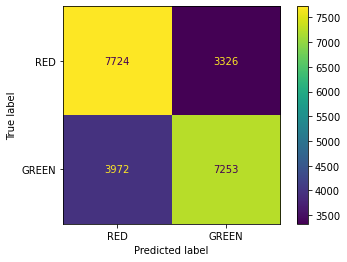


Model 6 MLP: Train: Classification Report
              precision    recall  f1-score   support

         RED       0.66      0.70      0.68     11050
       GREEN       0.69      0.65      0.67     11225

    accuracy                           0.67     22275
   macro avg       0.67      0.67      0.67     22275
weighted avg       0.67      0.67      0.67     22275

Model 6 MLP: Test: RMSE: 2.704260849728689
Model 6 MLP: Test: MAPE: 0.0011489848381676321
Model 6 MLP: Test: R2: 0.9999956144159222


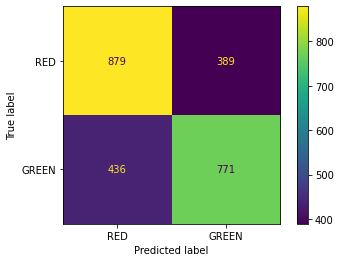


Model 6 MLP: Test: Classification Report
              precision    recall  f1-score   support

         RED       0.67      0.69      0.68      1268
       GREEN       0.66      0.64      0.65      1207

    accuracy                           0.67      2475
   macro avg       0.67      0.67      0.67      2475
weighted avg       0.67      0.67      0.67      2475



In [ ]:
#Prepare X - Y data
sma_span=20
smaUpDownMultiplier=1
y_multiplier = 1

dim_TATAMOTORS = deriveExtraDimensions(haDF_TATAMOTORS, sma_span=sma_span, smaUpDownMultiplier=smaUpDownMultiplier)
dim_ASIANPAINTS = deriveExtraDimensions(haDF_ASIANPAINTS, sma_span=sma_span, smaUpDownMultiplier=smaUpDownMultiplier)
dim_SBI = deriveExtraDimensions(haDF_SBI, sma_span=sma_span, smaUpDownMultiplier=smaUpDownMultiplier)

lagLength = 3
dataX_TATAMOTORS, dataY_TATAMOTORS, dataSupport_TATAMOTORS = createDataXY_usingLagPricesSMA(dim_TATAMOTORS, lagLength=lagLength)
dataX_ASIANPAINTS, dataY_ASIANPAINTS, dataSupport_ASIANPAINTS = createDataXY_usingLagPricesSMA(dim_ASIANPAINTS, lagLength=lagLength)
dataX_SBI, dataY_SBI, dataSupport_SBI = createDataXY_usingLagPricesSMA(dim_SBI, lagLength=lagLength)

dataX = np.array(joinMultipleDataLists([dataX_TATAMOTORS,dataX_ASIANPAINTS,dataX_SBI]))
dataY = np.array(joinMultipleDataLists([dataY_TATAMOTORS,dataY_ASIANPAINTS,dataY_SBI]))
dataSupport = np.array(joinMultipleDataLists([dataSupport_TATAMOTORS,dataSupport_ASIANPAINTS,dataSupport_SBI]))

#Pre-Clean data 
dataX, dataY, dataSupport, removedIndices = removeBadSamples([dataX, dataY, dataSupport])

#apply necessary scaling function
nonScaled_dataX = dataX
nonScaled_dataY = dataY
# dataX, dataY = applyZscoreScaling(dataX, dataY)
dataX, dataY = applyMinMaxScalingXY(dataX, dataY)
dataX, dataY, removedIndices = removeBadSamples([dataX, dataY], threshold=None)
dataSupport, nonScaled_dataX, nonScaled_dataY, removedIndices = removeBadSamples([dataSupport, nonScaled_dataX, nonScaled_dataY], removeIndices=removedIndices)

#testing new concept
dataY = dataY * y_multiplier

#split train  - test
(train_dataX, test_dataX, train_dataY, test_dataY
 , train_dataSupport, test_dataSupport
 , train_nonScaled_dataX, test_nonScaled_dataX
 , train_nonScaled_dataY, test_nonScaled_dataY
 ) = train_test_split(dataX, dataY, dataSupport, nonScaled_dataX, nonScaled_dataY, test_size=0.10, random_state=42)

#remove up_Close and down_Close from features
train_dataX = train_dataX[:,0:-2]
test_dataX = test_dataX[:,0:-2]

#Create model
# param_grid = {'C': [10,20], 'gamma': [1e-2] ,'kernel': ['rbf']}
# param_grid = {'epsilon': [0.001], 'C': [10], 'gamma':[0.001]}
# model_5_mlp = createModelWithOptimalParam(SVR(), param_grid, train_dataX, train_dataY)

param_grid = {'activation': ['relu'], 'hidden_layer_sizes':[(15,100)], 'batch_size':[1000], 'max_iter':[400], 'alpha': [1e-2]}
model_6_mlp = createModelWithOptimalParam(MLPRegressor(), param_grid, train_dataX, train_dataY)

pred = model_6_mlp.predict(train_dataX)
print(f'sma predict: RMSE: {mean_squared_error(train_dataY, pred, squared=False)}')

train_true_open = train_dataSupport[:,0]
train_true_close = train_dataSupport[:,1]
test_true_open = test_dataSupport[:,0]
test_true_close = test_dataSupport[:,1]

train_true_sma = train_nonScaled_dataY
test_true_sma = test_nonScaled_dataY


#Evaluate model
printScoresOfAllConfig(model_6_mlp, train_dataX, train_true_sma, train_true_open
                   , label='Model 6 MLP: Train true sma'
                   , inverseScaling=inverseMinMaxScalingXY
                   , nonScaled_dataX=train_nonScaled_dataX
                  #  , sma_span = sma_span
                  #  , partial_sma = train_dataSupport[:,2]  
                   , y_multiplier=y_multiplier                     
                   )
yPredictedTrain = publishModelScores(model_6_mlp, train_dataX, train_true_close, train_true_open
                   , label='Model 6 MLP: Train'
                   , inverseScaling=inverseMinMaxScalingXY
                   , nonScaled_dataX=train_nonScaled_dataX
                   , sma_span = sma_span
                   , partial_sma = train_dataSupport[:,2]  
                   , y_multiplier=y_multiplier  
                   , returnYpredicted=True                   
                   )
publishModelScores(model_6_mlp, test_dataX, test_true_close, test_true_open
                   , label='Model 6 MLP: Test'
                   , inverseScaling=inverseMinMaxScalingXY
                   , nonScaled_dataX=test_nonScaled_dataX
                   , sma_span = sma_span
                   , partial_sma = test_dataSupport[:,2]
                  , y_multiplier=y_multiplier    
                   )


#**Validate Models** 
performance on new stocks which are not part of Training/Testing

##Data for validation

In [ ]:
dataFiles_INDUSIND = []
dataFiles_INDUSIND.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/indusind_2021-Aug_to_2022-May-1.json")

rawDF_INDUSIND = cleanRawData(createDataFrameFromListOfFiles(dataFiles_INDUSIND))
htfDF_INDUSIND = convertToHTF(rawDF_INDUSIND,candleTimeDuration)
haDF_INDUSIND = createHeikinAshiOhlc(htfDF_INDUSIND[htfDF_INDUSIND.index.to_series().between('2022-03-24 09:15', '2022-03-24 15:30')])

dataFiles_TATAPOWER = []
dataFiles_TATAPOWER.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/TATAPOWER_2021-Aug_to_2022-May-5.json")

rawDF_TATAPOWER = cleanRawData(createDataFrameFromListOfFiles(dataFiles_TATAPOWER))
htfDF_TATAPOWER = convertToHTF(rawDF_TATAPOWER,candleTimeDuration)
haDF_TATAPOWER = createHeikinAshiOhlc(htfDF_TATAPOWER[htfDF_TATAPOWER.index.to_series().between('2022-03-24 09:15', '2022-03-24 15:30')])



##Model 1: Visualization

Model 1: EMA: RMSE: 1.0922456730752268
Model 1: EMA: MAPE: 0.0008919824620675733
Model 1: EMA: R2: 0.8790161731745293


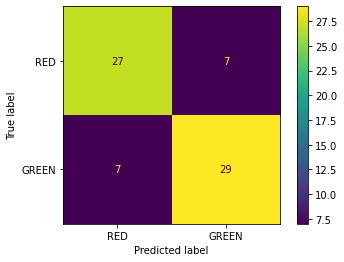


Model 1: EMA: Classification Report
              precision    recall  f1-score   support

         RED       0.79      0.79      0.79        34
       GREEN       0.81      0.81      0.81        36

    accuracy                           0.80        70
   macro avg       0.80      0.80      0.80        70
weighted avg       0.80      0.80      0.80        70



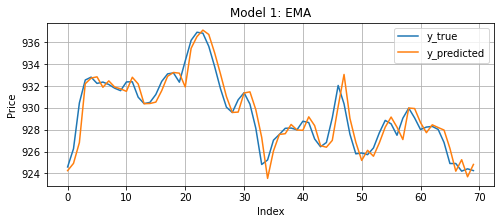

In [ ]:
lagLength = 5

#Prepare X - Y data
(dataX_v, dataY_v, dataSupport_v
, nonScaled_dataX_v, nonScaled_dataY_v) = prepareXYdata(createDataXY_usingLagPrices
                                        ,haDF_INDUSIND
                                        ,lagLength=lagLength, tgtColName='Close'
                                        )

#Create model
# model_1_EMA = EMA(alpha=1.5)
# model_1_DES = DES(alpha=1.5, gamma=0.2)
# model_1_TEMA = TEMA(alpha=1)

#Print scores
publishModelScores(model_1, dataX_v, dataY_v, dataSupport_v[:,0], label='Model 1: EMA', plotCharts=True)
# publishModelScores(model_1_DES, dataX_v, dataY_v, dataSupport_v[:,0], label='Model 1: DES', plotCharts=True)
# publishModelScores(model_1_TEMA, dataX_v, dataY_v, dataSupport_v[:,0], label='Model 1: TEMA', plotCharts=True)

##Model 2: Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in double_scalars



Model 2: MLP: RMSE: 1.2821478354477187
Model 2: MLP: MAPE: 0.0010336219276231415
Model 2: MLP: R2: 0.8482950422095601


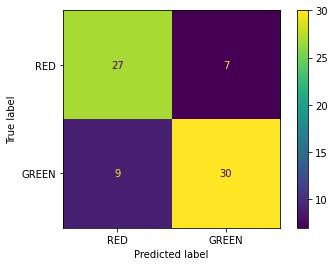


Model 2: MLP: Classification Report
              precision    recall  f1-score   support

         RED       0.75      0.79      0.77        34
       GREEN       0.81      0.77      0.79        39

    accuracy                           0.78        73
   macro avg       0.78      0.78      0.78        73
weighted avg       0.78      0.78      0.78        73



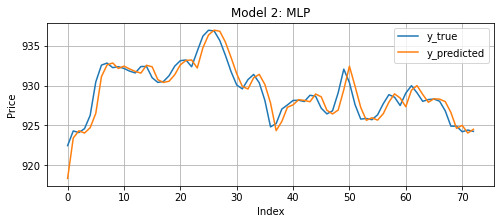

In [ ]:
#Derive dimensions
ema_alpha=1.3
dema_alpha=1.1
tema_alpha=1.1

dim_INDUSIND = deriveExtraDimensions(haDF_INDUSIND, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)

#Prepare X - Y data
(dataX_v, dataY_v, dataSupport_v
, nonScaled_dataX_v, nonScaled_dataY_v) = prepareXYdata(createDataXY_usingPriceDerivatives
                                        ,dim_INDUSIND
                                        ,tgtColName='Close'
                                        ,supColName=None
                                        ,upDownMultiplier=None
                                        ,scalingFunc=applyZscoreScaling
                                        ,threshold=None
                                        ,removeUpDownValues=False
                                      )


#Evaluate model
publishModelScores(model_2, dataX_v, nonScaled_dataY_v, dataSupport_v[:,0]
                   , label='Model 2: MLP'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=nonScaled_dataX_v
                   , plotCharts=True
                   )


##Model 3: Visualization

Model 3: MLP: RMSE: 1.2702831583683711
Model 3: MLP: MAPE: 0.0010418626110272984
Model 3: MLP: R2: 0.8328172544812006


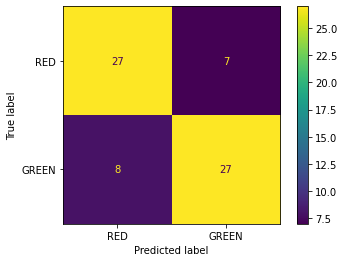


Model 3: MLP: Classification Report
              precision    recall  f1-score   support

         RED       0.77      0.79      0.78        34
       GREEN       0.79      0.77      0.78        35

    accuracy                           0.78        69
   macro avg       0.78      0.78      0.78        69
weighted avg       0.78      0.78      0.78        69



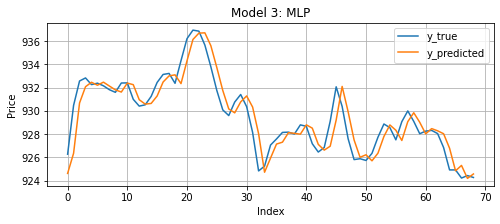

In [ ]:
#Prepare X - Y data
lagLength = 3

(dataX_v, dataY_v, dataSupport_v
 , nonScaled_dataX_v, nonScaled_dataY_v) = prepareXYdata(createDataXY_usingLagPrices
                                          ,haDF_INDUSIND
                                          ,lagLength=lagLength, tgtColName='Close'
                                          ,supColName=None
                                          ,upDownMultiplier=0.5
                                          ,scalingFunc=applyZscoreScaling
                                          ,threshold=None
                                          ,removeUpDownValues=True
                                         )


#Evaluate model
publishModelScores(model_3_mlp, dataX_v, nonScaled_dataY_v, dataSupport_v[:,0]
                   , label='Model 3: MLP'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=nonScaled_dataX_v
                   , plotCharts=True
                   )

##Model 4: Visualization

Model 4 MLP: RMSE: 1.063610693085398
Model 4 MLP: MAPE: 0.0008766013932824121
Model 4 MLP: R2: 0.8827924028951504


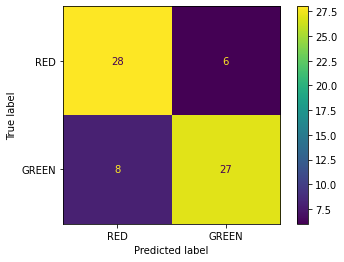


Model 4 MLP: Classification Report
              precision    recall  f1-score   support

         RED       0.78      0.82      0.80        34
       GREEN       0.82      0.77      0.79        35

    accuracy                           0.80        69
   macro avg       0.80      0.80      0.80        69
weighted avg       0.80      0.80      0.80        69



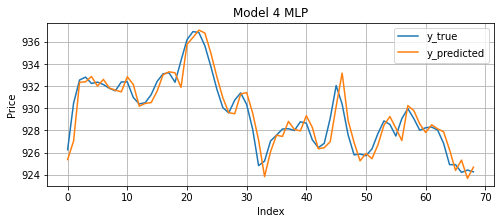

In [ ]:
upDownMultiplier=1.5
ema_alpha=0.5

dim_INDUSIND = deriveExtraDimensions(haDF_INDUSIND, ema_alpha=ema_alpha)


lagLength = 5
(dataX_v, dataY_v, dataSupport_v
, nonScaled_dataX_v, nonScaled_dataY_v) = prepareXYdata(createDataXY_usingLagPrices
                                        ,dim_INDUSIND                                       
                                        ,lagLength=lagLength, tgtColName='ema_Close'
                                        ,supColName='ema_Close'
                                        ,upDownMultiplier=upDownMultiplier
                                        ,scalingFunc=applyZscoreScaling
                                        ,threshold=None
                                        ,removeUpDownValues=True
                                        )

true_open = dataSupport_v[:,0]
true_close = dataSupport_v[:,1]

#Evaluate model
y_predicted = publishModelScores(model_4_mlp, dataX_v, true_close, true_open
                   , label='Model 4 MLP'
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=nonScaled_dataX_v
                   , ema_alpha = ema_alpha
                   , previous_EMA = dataSupport_v[:,2]
                   , plotCharts=True
                   , returnYpredicted=True
                   )



#Data Analysis

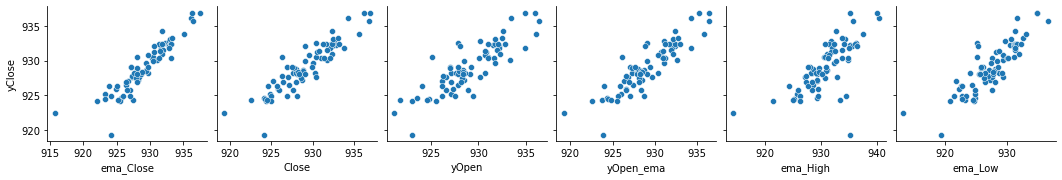

In [ ]:
data = dim_INDUSIND.copy()
data[['yClose', 'yOpen', 'yOpen_ema']] = data[['yClose', 'yOpen', 'yOpen_ema']].shift(-1)
sns.pairplot(data
            ,x_vars=['ema_Close','Close'
            ,'yOpen', 'yOpen_ema'
            , 'ema_High','ema_Low']
            ,y_vars=['yClose'])

In [ ]:
plotCandlestickChart(nextOpen,actualValues,highSeries=None,lowSeries=None)
plotCandlestickChart(nextOpen,ema_3,highSeries=None,lowSeries=None)

ValueError: ignored

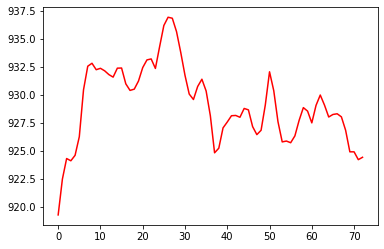

In [ ]:
ema_Close_2 = applyEMA(Close, alpha=3**(1/2))
ema_High_2 = applyEMA(High, alpha=5**(1/3))
ema_Low_2 = applyEMA(Low, alpha=5**(1/3))
ema_yOpen_2 = applyEMA(yOpen, alpha=3**(1/2))

ema_Predicted = (ema_High_2 + ema_Low_2 + ema_Close_2 )/3

span = 2
weights = np.arange(1,span+1)
data['wma_Close'] = data['Close'].rolling(span).apply(lambda x: np.average(x, weights=weights))

wma_Close = data.wma_Close.to_numpy()

plt.plot(Close[1:], label='yClose', color='red')
# plt.plot(ema_Close_2, label='Close2')
# plt.plot(ema_High_2, label='High2')
# plt.plot(ema_Low_2, label='Low2')
# plt.plot(ema_Predicted, label='HL')
plt.plot((wma_Close + 2*ema_Predicted)/3 , label='WMA')
plt.legend()

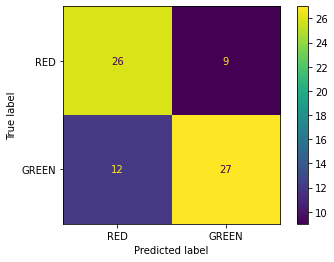


None: Classification Report
              precision    recall  f1-score   support

         RED       0.68      0.74      0.71        35
       GREEN       0.75      0.69      0.72        39

    accuracy                           0.72        74
   macro avg       0.72      0.72      0.72        74
weighted avg       0.72      0.72      0.72        74



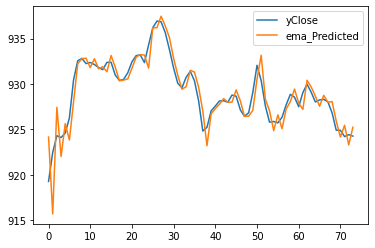

In [ ]:
# ema_Predicted = (ema_High_2 + ema_Low_2 + ema_Close_2 )/3
actColors = identifyCandleColor(yOpen,yClose)
predColors = identifyCandleColor(yOpen, ema_Predicted)
evaluateColorClassificationScore(actColors, predColors)

plt.plot(yClose, label='yClose')
plt.plot(ema_Close, label='ema_Predicted')
plt.legend()


In [ ]:
dataX_v.shape

(74, 7)

In [ ]:
dataY_v.shape

(74,)

In [ ]:
dataV = pd.DataFrame(dataX_v, columns=['ema_Close' , 'ema_High' , 'ema_Low' , 'ema_Open' , 'Close' , 'y_ema_Open' , 'yOpen'])
dataV['yClose'] = dataY_v

In [ ]:
dataV

,ema_Close,ema_High,ema_Low,ema_Open,Close,y_ema_Open,yOpen,yClose
0,924.162500,935.100000,919.400000,922.000000,924.1625,923.872780,923.081250,919.2750
1,915.697102,914.282914,913.251220,923.872780,919.2750,919.205501,921.178125,922.4750
2,927.436766,933.365066,923.295002,919.205501,922.4750,923.745313,921.826562,924.3125
3,922.025379,921.301217,920.751590,923.745313,924.3125,922.574825,923.069531,924.1125
4,925.640379,929.266542,924.766382,922.574825,924.1125,924.334919,923.591016,924.6000
...,...,...,...,...,...,...,...,...
69,925.932979,929.344909,922.781424,928.163708,926.8375,927.048343,927.519752,924.9125
70,924.165458,926.183644,923.333214,927.048343,924.9125,925.606900,926.216126,924.9125
71,925.459373,926.239904,924.747929,925.606900,924.9125,925.533137,925.564313,924.2125
72,923.299726,925.069746,922.759658,925.533137,924.2125,924.416431,924.888406,924.4250


In [ ]:
vX, vY = calcZscoreXY(dataX_v, dataY_v)

In [ ]:
dataVz = pd.DataFrame(vX, columns=['ema_Close' , 'ema_High' , 'ema_Low' , 'ema_Open' , 'Close' , 'y_ema_Open' , 'yOpen'])
dataVz['yClose'] = vY

In [ ]:
dataVz

,ema_Close,ema_High,ema_Low,ema_Open,Close,y_ema_Open,yOpen,yClose
0,-0.082279,2.302509,-1.120684,-0.553786,-0.082279,-0.145449,-0.318032,-1.147939
1,-0.675427,-1.071463,-1.360385,1.614134,0.326547,0.307084,0.859509,1.222693
2,0.690431,2.074022,-0.276204,-1.230642,-0.467582,-0.171107,-0.618919,-0.038733
3,-0.433345,-1.043076,-1.505852,1.014809,1.492371,0.029279,0.445813,1.323974
4,0.373207,2.196343,-0.066214,-1.168069,-0.394968,-0.283142,-0.657156,-0.149867
...,...,...,...,...,...,...,...,...
69,-0.453587,1.323007,-2.094604,0.707955,0.017398,0.127184,0.372647,-0.984951
70,-0.990154,0.693553,-1.684468,1.414944,-0.366921,0.212395,0.720652,-0.366921
71,0.047580,1.762908,-1.515918,0.371793,-1.154250,0.209686,0.278201,-2.692598
72,-1.106352,0.829369,-1.696979,1.336141,-0.108128,0.114894,0.631054,0.124265


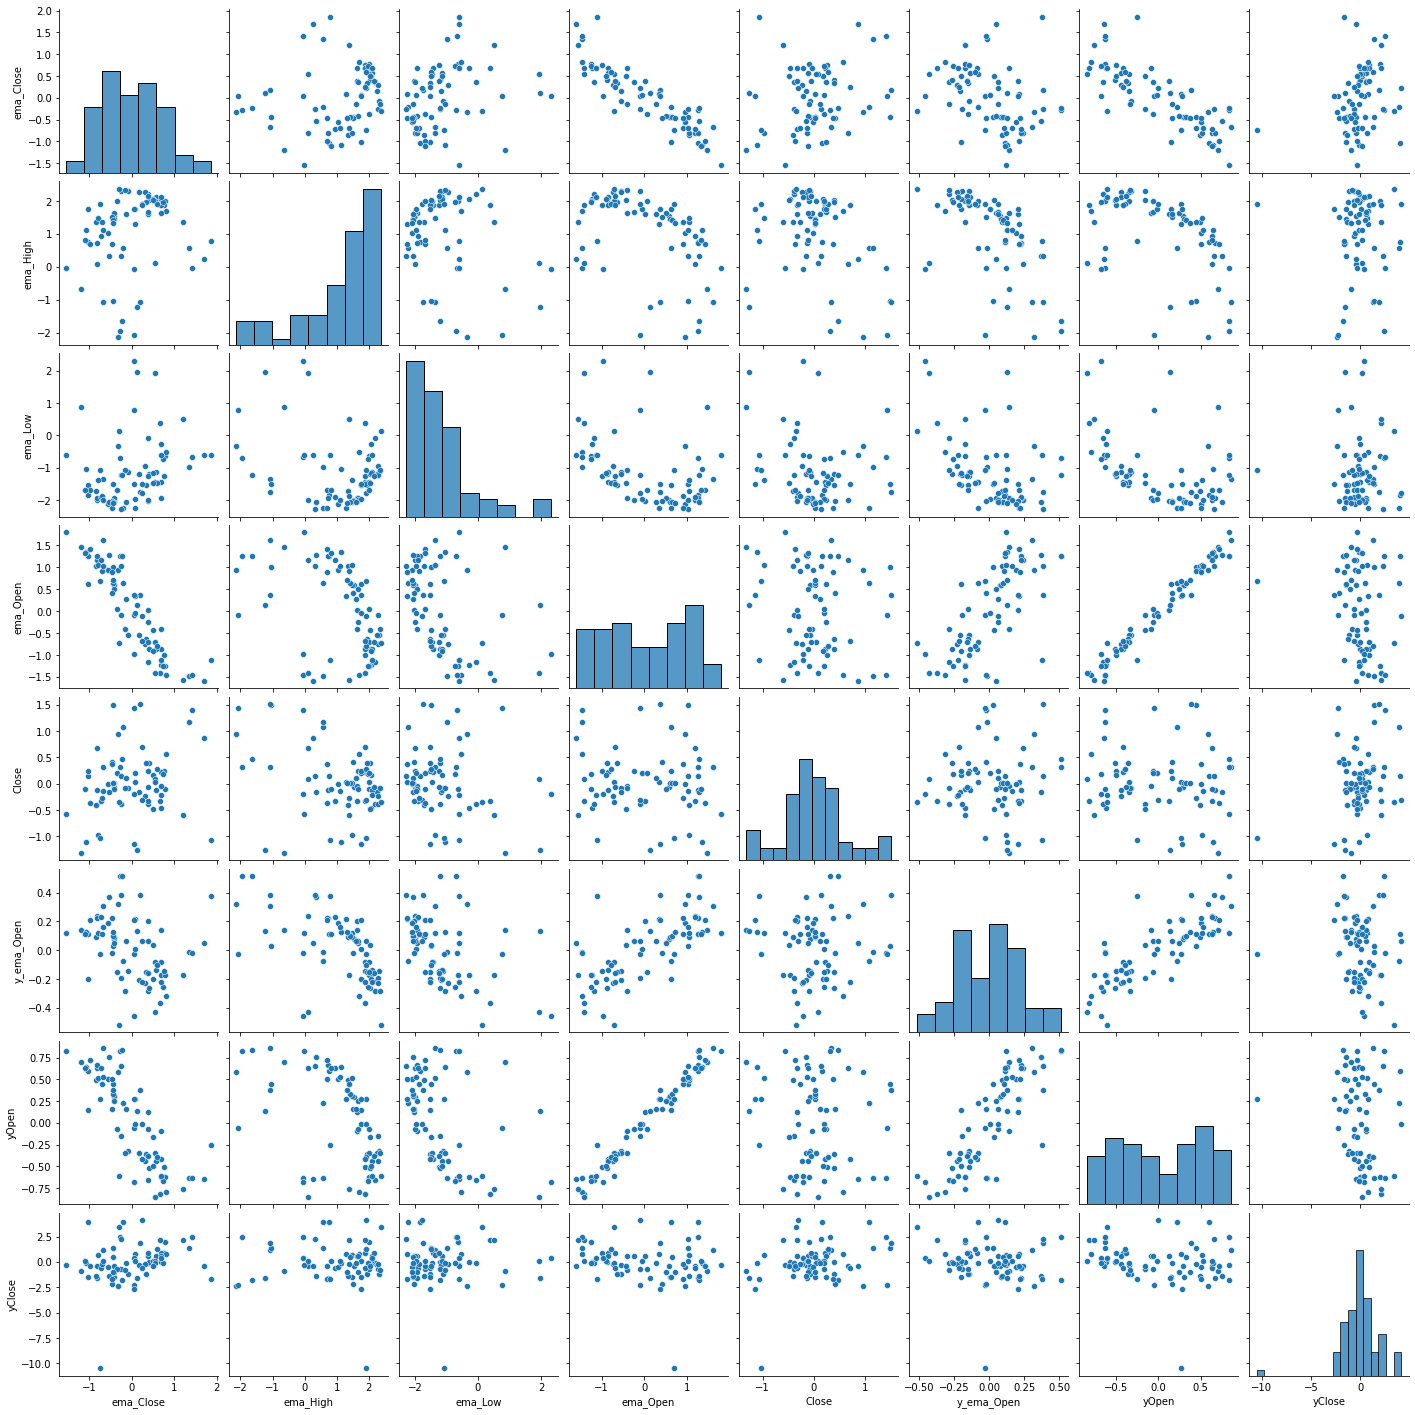

In [ ]:
sns.pairplot(dataVz)

No handles with labels found to put in legend.


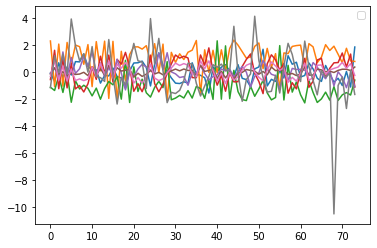

In [ ]:
plt.plot(dataVz)
plt.legend()

In [ ]:
np.min([4,2,3])

2

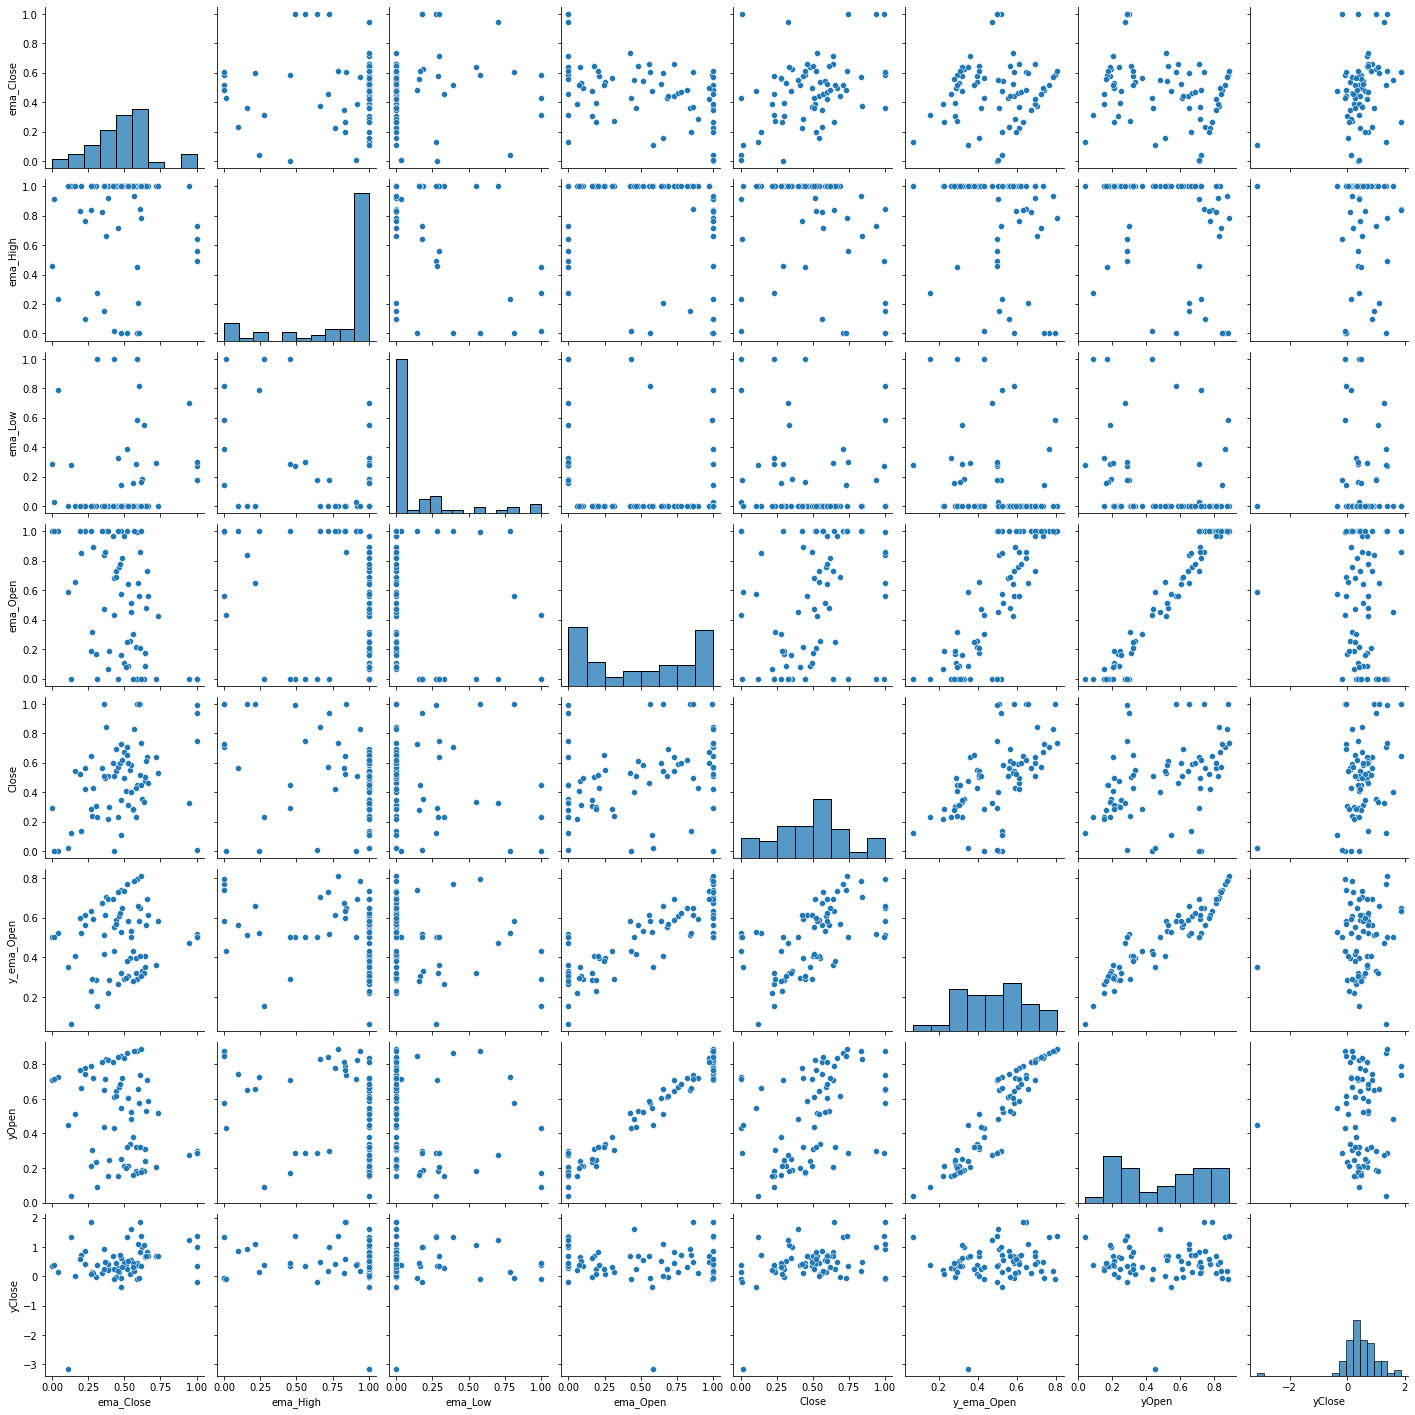

In [ ]:
vX, vY = applyMinMaxScalingXY(dataX_v, dataY_v)
dataVminmax = pd.DataFrame(vX, columns=['ema_Close' , 'ema_High' , 'ema_Low' , 'ema_Open' , 'Close' , 'y_ema_Open' , 'yOpen'])
dataVminmax['yClose'] = vY

sns.pairplot(dataVminmax)

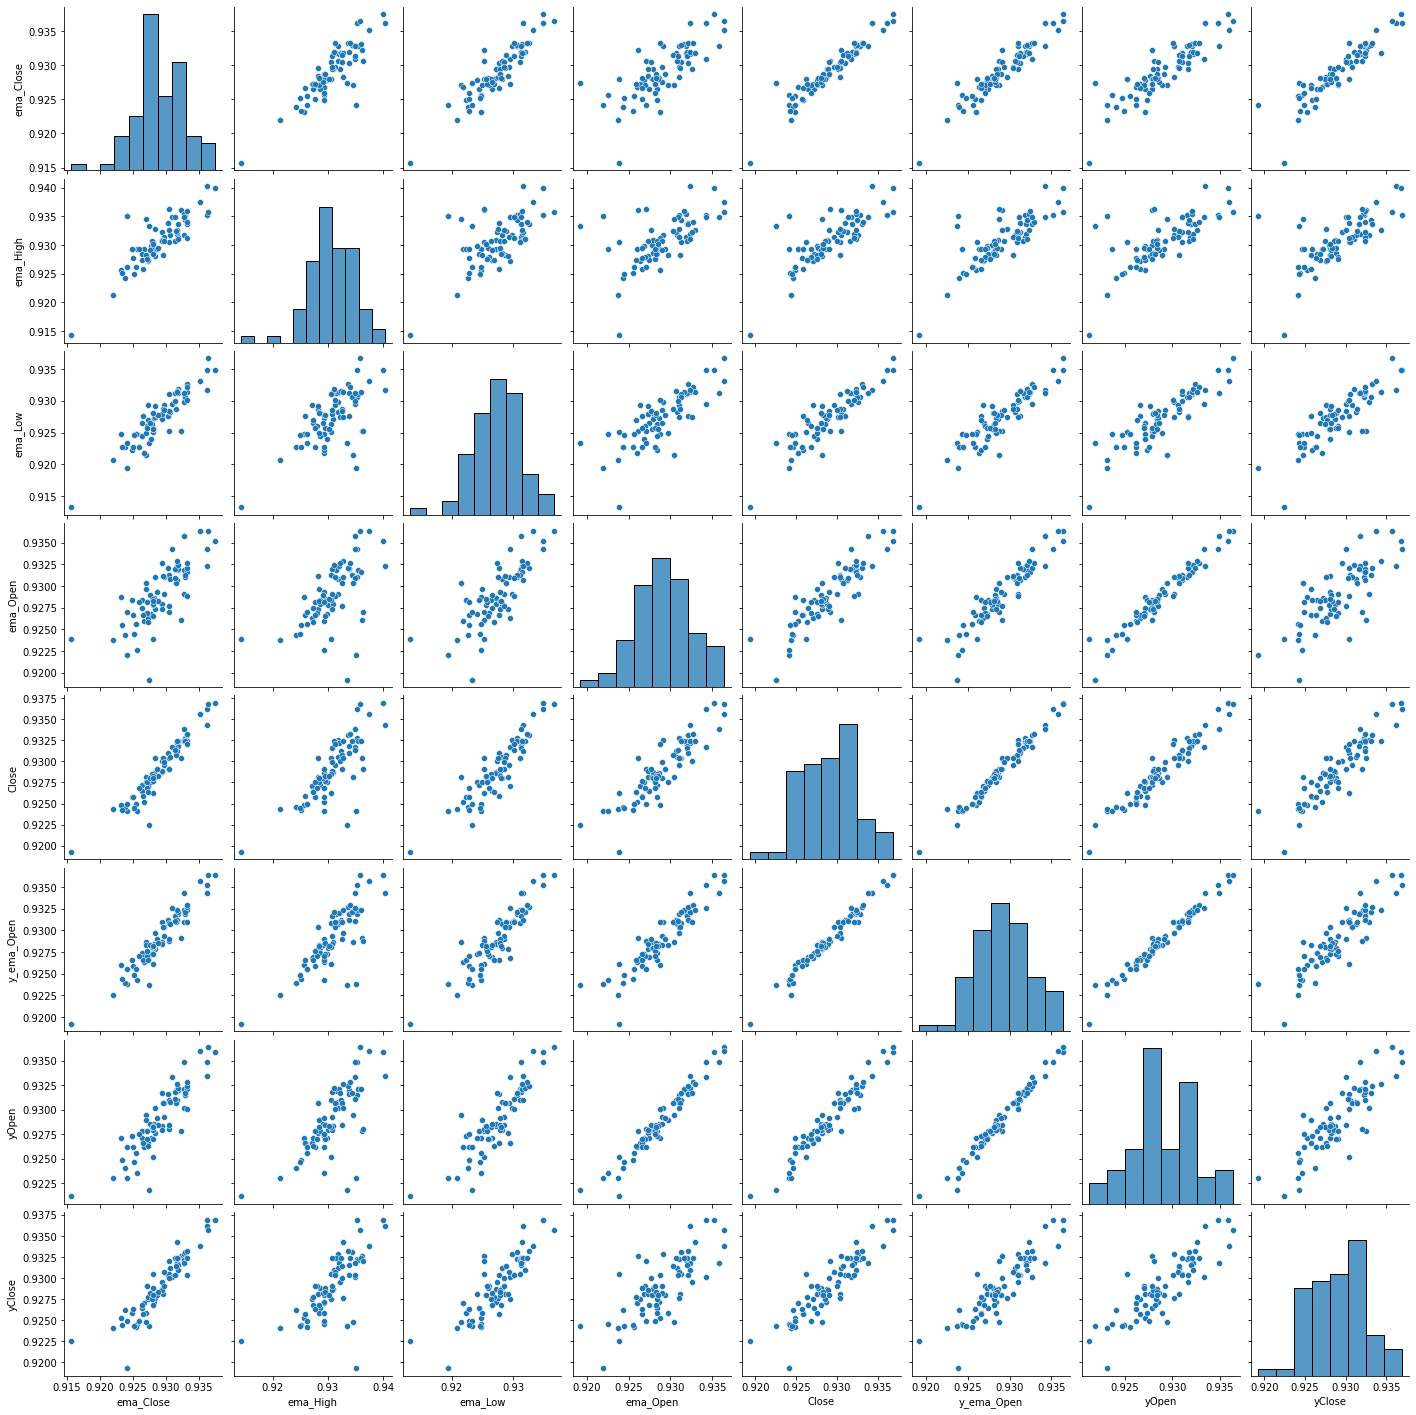

In [ ]:
vX, vY = applyDecimalScaling(dataX_v, dataY_v)
dataVd = pd.DataFrame(vX, columns=['ema_Close' , 'ema_High' , 'ema_Low' , 'ema_Open' , 'Close' , 'y_ema_Open' , 'yOpen'])
dataVd['yClose'] = vY

sns.pairplot(dataVd)

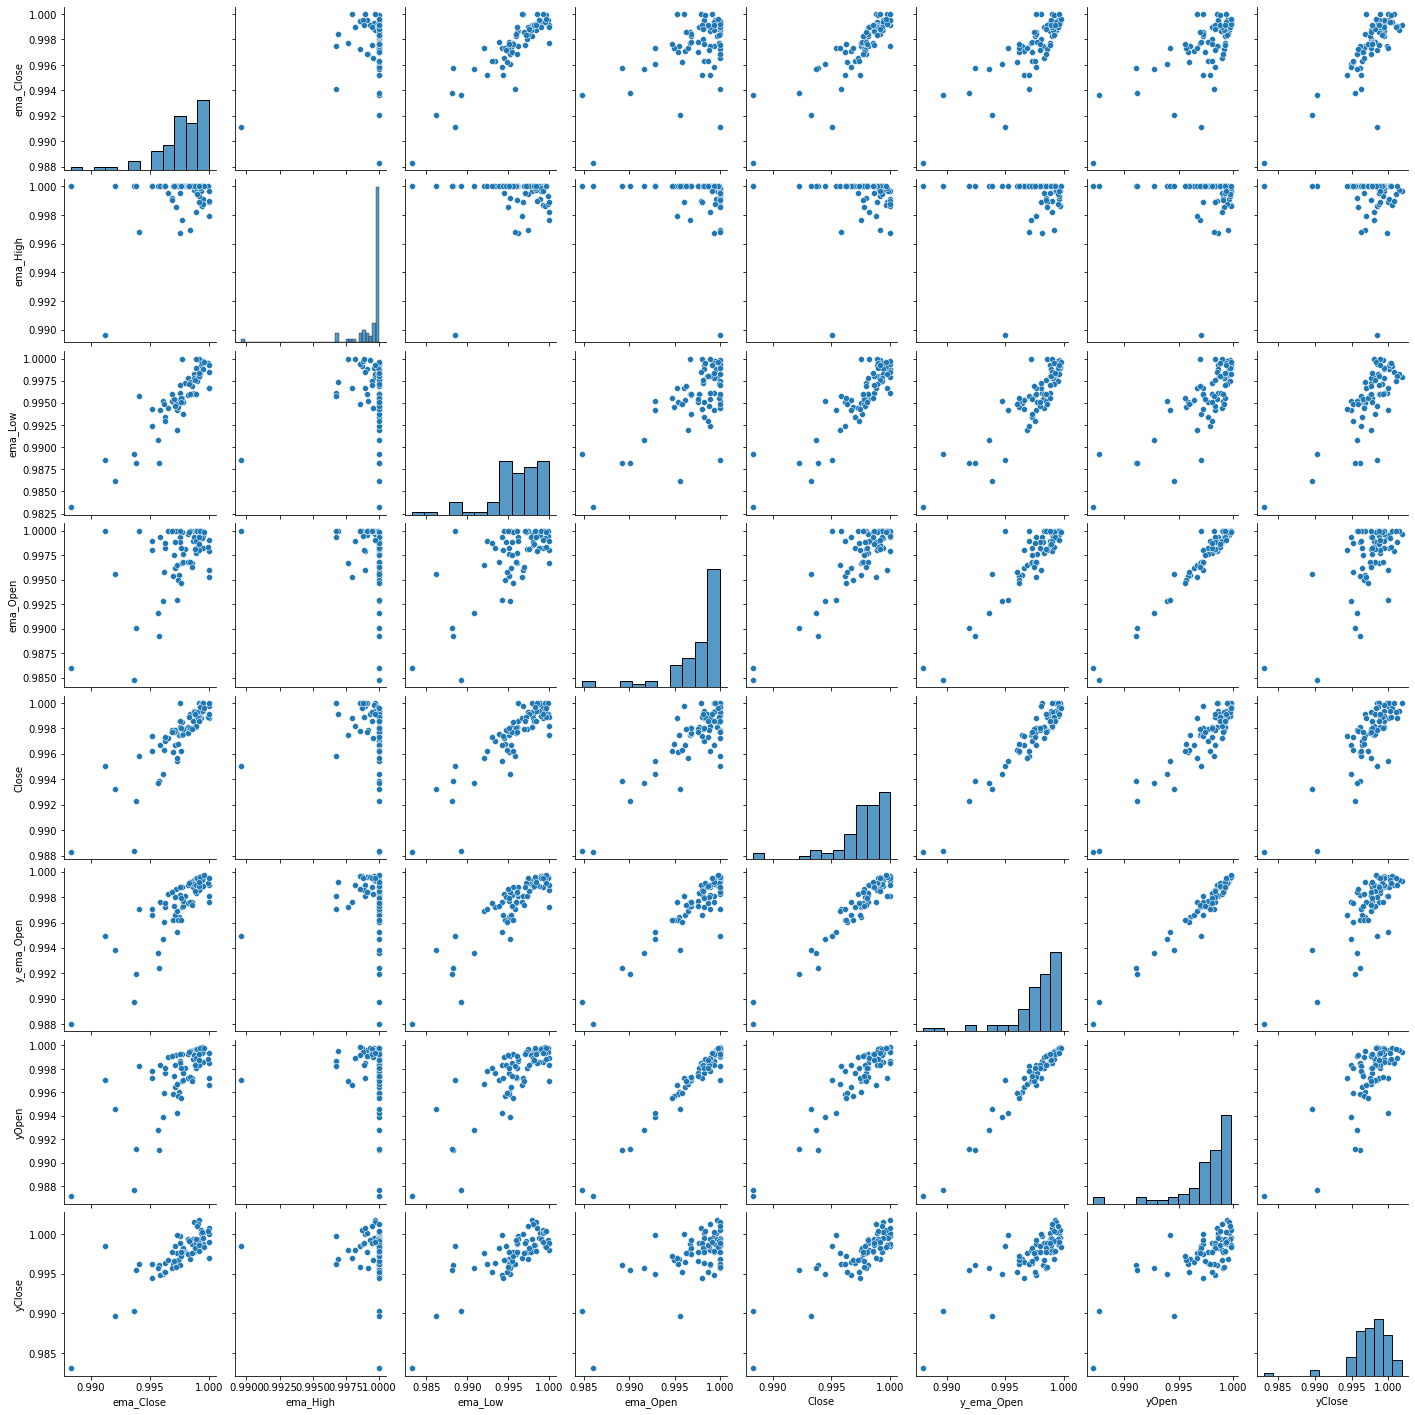

In [ ]:
vX, vY = applyDecimalScaling(dataX_v, dataY_v)
dataVd = pd.DataFrame(vX, columns=['ema_Close' , 'ema_High' , 'ema_Low' , 'ema_Open' , 'Close' , 'y_ema_Open' , 'yOpen'])
dataVd['yClose'] = vY

sns.pairplot(dataVd)

In [ ]:
dataFiles_INDUSIND = []
dataFiles_INDUSIND.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/indusind_2021-Aug_to_2022-May-1.json")

rawDF_INDUSIND = cleanRawData(createDataFrameFromListOfFiles(dataFiles_INDUSIND))
htfDF_INDUSIND = convertToHTF(rawDF_INDUSIND,candleTimeDuration)
haDF_INDUSIND = createHeikinAshiOhlc(htfDF_INDUSIND[htfDF_INDUSIND.index.to_series().between('2022-03-24 09:15', '2022-03-24 15:30')])

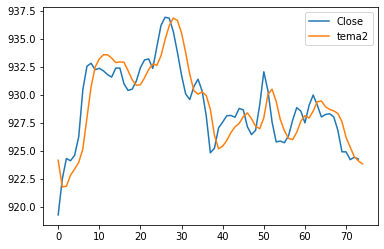

In [ ]:
Close = haDF_INDUSIND.Close.to_numpy()
plt.plot(Close[1:], label='Close')
alpha = 0.2
# plt.plot(applyEMA(Close, alpha=alpha, emaOrigin=None), label='ema')
# plt.plot(applyDoubleExpSmoothing(Close, alpha=1.5, gamma=0.2), label='dema')
# plt.plot(applyDEMA(Close, alpha=alpha), label='dema2')
plt.plot(applyTEMA(Close, alpha=alpha), label='tema2')
plt.legend()

In [ ]:
applyDoubleExpSmoothing(Close, alpha=0, gamma=0)[-1]

562.4874999999967

Model_2: Validation: RMSE: 1.2775119504584798
Model_2: Validation: MAPE: 0.0009984356493745643
Model_2: Validation: R2: 0.8493901035963264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


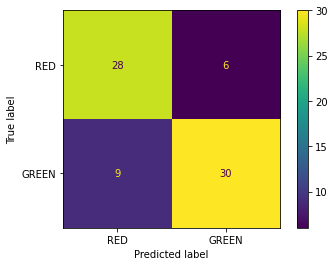


Model_2: Validation: Classification Report
              precision    recall  f1-score   support

         RED       0.76      0.82      0.79        34
       GREEN       0.83      0.77      0.80        39

    accuracy                           0.79        73
   macro avg       0.80      0.80      0.79        73
weighted avg       0.80      0.79      0.79        73



In [ ]:
dataFiles_INDUSIND = []
dataFiles_INDUSIND.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/indusind_2021-Aug_to_2022-May-1.json")

rawDF_INDUSIND = cleanRawData(createDataFrameFromListOfFiles(dataFiles_INDUSIND))
htfDF_INDUSIND = convertToHTF(rawDF_INDUSIND,candleTimeDuration)
haDF_INDUSIND = createHeikinAshiOhlc(htfDF_INDUSIND[htfDF_INDUSIND.index.to_series().between('2022-03-24 09:15', '2022-03-24 15:30')])

#Derive dimensions
dim_INDUSIND = deriveExtraDimensions(haDF_INDUSIND, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)

#Prepare X - Y data
dataX_INDUSIND, dataY_INDUSIND, dataSupport_INDUSIND = createDataXY_usingPriceDerivatives(dim_INDUSIND)

dataX_v = np.array(joinMultipleDataLists([dataX_INDUSIND]))
dataY_v = np.array(joinMultipleDataLists([dataY_INDUSIND]))
dataSupport_v = np.array(joinMultipleDataLists([dataSupport_INDUSIND]))


nonScaled_dataX_v = dataX_v
dataX_v, dataY_v = applyZscoreScaling(dataX_v, dataY_v)
dataX_v, dataY_v, dataSupport_v, nonScaled_dataX_v = removeBadSamples([dataX_v, dataY_v, dataSupport_v, nonScaled_dataX_v])

publishModelScores(model_2, dataX_v, dataY_v, dataSupport_v[:,0]
                   , label='Model_2: Validation'
                   , inverseScaling = inverseZscoreScaling
                   , nonScaled_dataX=nonScaled_dataX_v)

In [ ]:
dataFiles_INDUSIND = []
dataFiles_INDUSIND.append("https://raw.githubusercontent.com/DeboBuiz/MSc-Thesis-DataSets/main/indusind_2021-Aug_to_2022-May-1.json")

rawDF_INDUSIND = cleanRawData(createDataFrameFromListOfFiles(dataFiles_INDUSIND))
htfDF_INDUSIND = convertToHTF(rawDF_INDUSIND,candleTimeDuration)
haDF_INDUSIND = createHeikinAshiOhlc(htfDF_INDUSIND[htfDF_INDUSIND.index.to_series().between('2022-03-24 09:15', '2022-03-24 15:30')])
baseShifted_INDUSIND = shiftBase(haDF_INDUSIND)
#Derive dimensions
ema_alpha = 0.5
dema_alpha = 0.5
tema_alpha = 0.5
dim_INDUSIND = deriveExtraDimensions(haDF_INDUSIND, ema_alpha=ema_alpha, dema_alpha=dema_alpha, tema_alpha=tema_alpha)


-1.9012134143446033


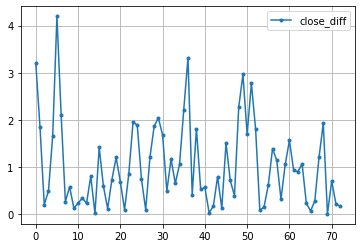

In [ ]:
close_diff = dim_INDUSIND.diff_Close.dropna().abs().to_numpy()
ema_close_diff = applyEMA(close_diff, alpha=0.3) * 1.5
plt.plot(close_diff[1:], '.-',label='close_diff')
# plt.plot(ema_close_diff, '*',label='ema_close_diff')
plt.legend()
plt.grid()

print(r2_score(close_diff[1:], ema_close_diff[0:-1]))

In [ ]:
applyEMA(close_diff,alpha=0.2)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

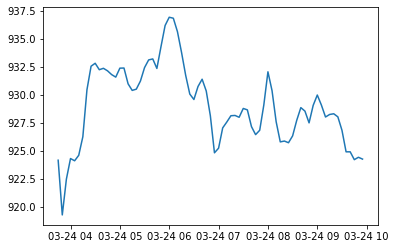

In [ ]:
plt.plot(haDF_INDUSIND.Close)

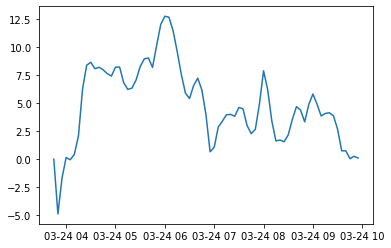

In [ ]:
plt.plot(baseShifted_INDUSIND.Close)

In [ ]:
data = pd.DataFrame(train_dataX, columns=['ema_Close' , 'dema_Close' , 'tema_Close', 'Close', 'up_Close', 'down_Close'])
data['yClose'] = train_dataY
data['yPredicted'] = model_2.predict(train_dataX)
data.describe()

,ema_Close,dema_Close,tema_Close,Close,up_Close,down_Close,yClose,yPredicted
count,29090.000000,29090.000000,29090.000000,29090.000000,29090.000000,29090.000000,29090.000000,29090.000000
mean,-0.006197,0.005867,0.015032,-0.004901,1.800262,-1.810063,-0.013263,-0.017326
std,0.750549,1.286656,1.065104,0.478078,0.550162,0.553679,1.190346,0.626201
min,-2.137096,-2.919178,-2.763275,-1.304118,-1.304118,-2.853405,-2.998536,-1.643509
25%,-0.614251,-1.143690,-0.822178,-0.439419,1.485200,-2.234280,-0.833003,-0.494124
50%,-0.014842,0.017903,0.019565,-0.006954,1.933912,-1.943209,-0.002943,-0.010508
75%,0.604217,1.170974,0.847565,0.424532,2.224174,-1.511106,0.792571,0.459223
max,2.117965,2.949564,2.959168,1.135116,2.832069,1.080822,2.998260,1.737601


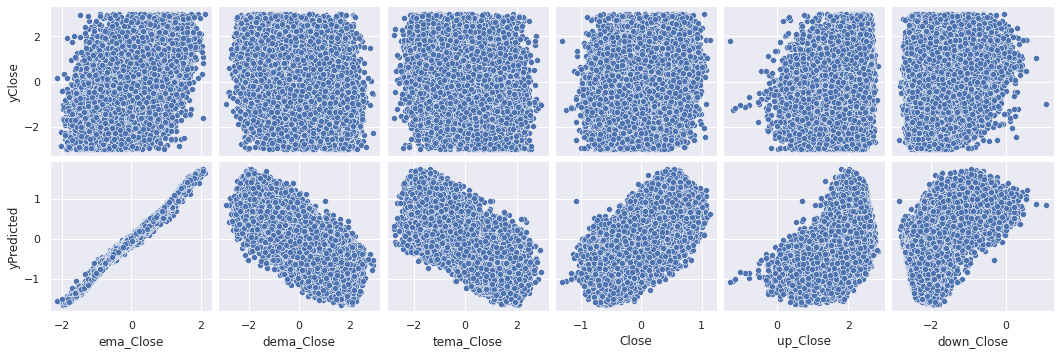

In [ ]:
sns.pairplot(data
             ,x_vars = ['ema_Close','dema_Close','tema_Close','Close','up_Close','down_Close']
             ,y_vars = ['yClose','yPredicted']
             )

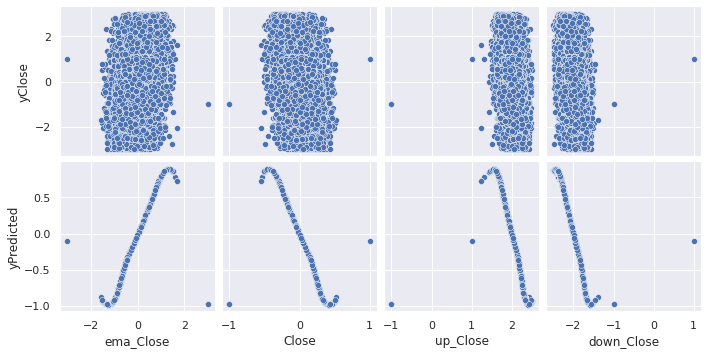

In [ ]:
data = pd.DataFrame(train_dataX, columns=['ema_Close' , 'Close', 'up_Close', 'down_Close'])
data['yClose'] = train_dataY
data['yPredicted'] = model_2.predict(train_dataX)
data.describe()
sns.pairplot(data
             ,x_vars = ['ema_Close','Close','up_Close','down_Close']
             ,y_vars = ['yClose','yPredicted']
             )

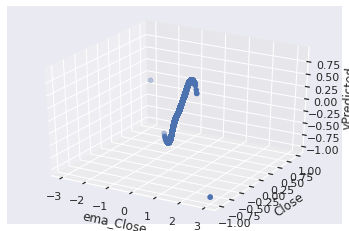

In [ ]:
sns.set(style = "darkgrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x=data['ema_Close']
y=data['Close']
z=data['yPredicted']

ax.set_xlabel("ema_Close")
ax.set_ylabel("Close")
ax.set_zlabel("yPredicted")

ax.scatter(x, y, z)

plt.show()

Model-3 Analysis

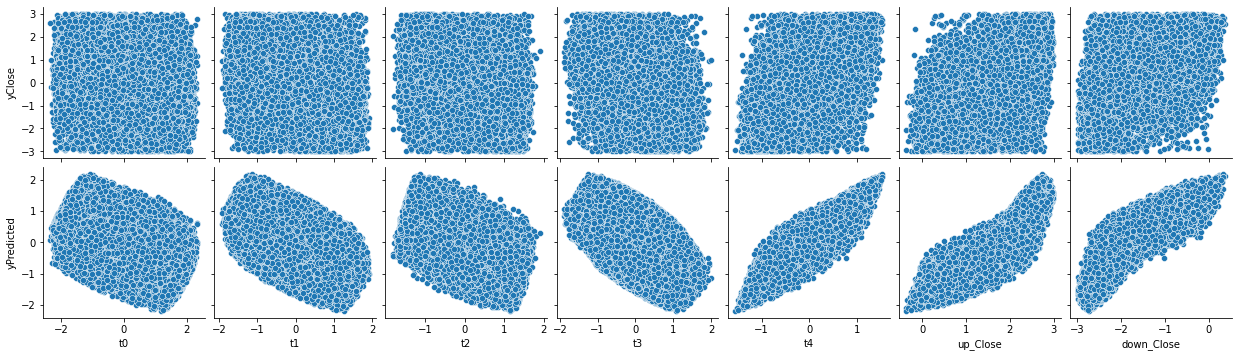

In [ ]:
data = pd.DataFrame(train_dataX, columns=['t0','t1','t2','t3','t4','up_Close','down_Close'])
data['yClose'] = train_dataY
data['yPredicted'] = model_3.predict(train_dataX)
data.describe()
sns.pairplot(data
             ,x_vars = ['t0','t1','t2','t3','t4','up_Close','down_Close']
             ,y_vars = ['yClose','yPredicted']
             )

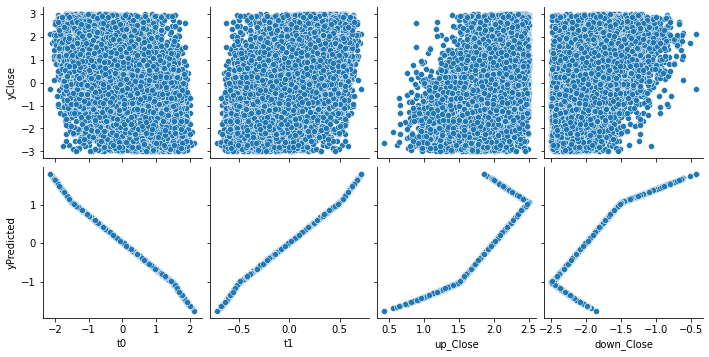

In [ ]:
data = pd.DataFrame(train_dataX, columns=['t0','t1','up_Close','down_Close'])
data['yClose'] = train_dataY
data['yPredicted'] = model_3.predict(train_dataX)
data.describe()
sns.pairplot(data
             ,x_vars = ['t0','t1','up_Close','down_Close']
             ,y_vars = ['yClose','yPredicted']
             )

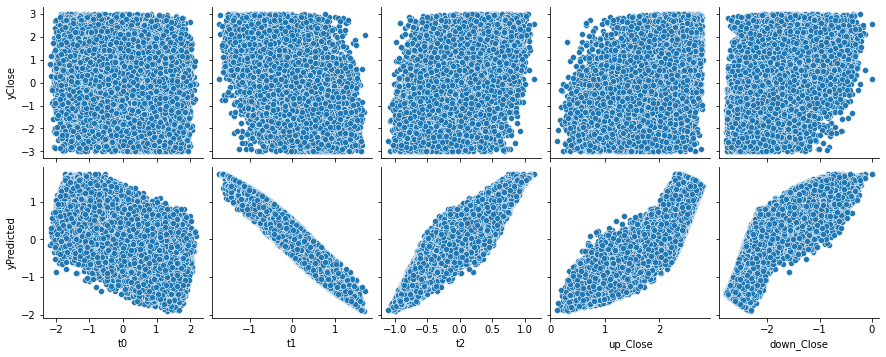

In [ ]:
data = pd.DataFrame(train_dataX, columns=['t0','t1','t2','up_Close','down_Close'])
data['yClose'] = train_dataY
data['yPredicted'] = model_3.predict(train_dataX)
data.describe()
sns.pairplot(data
             ,x_vars = ['t0','t1','t2','up_Close','down_Close']
             ,y_vars = ['yClose','yPredicted']
             )

In [ ]:
rawDF_INDUSIND['Close']

TradeTime
2021-08-30T09:15:00+0530    993.80
2021-08-30T09:16:00+0530    995.45
2021-08-30T09:17:00+0530    993.00
2021-08-30T09:18:00+0530    994.25
2021-08-30T09:19:00+0530    995.00
                             ...  
2022-04-29T15:25:00+0530    977.30
2022-04-29T15:26:00+0530    978.05
2022-04-29T15:27:00+0530    976.60
2022-04-29T15:28:00+0530    977.35
2022-04-29T15:29:00+0530    977.50
Name: Close, Length: 61875, dtype: float64

In [ ]:
coln='Close'
open='Open'
rawDF_INDUSIND[f'new{coln}'] = rawDF_INDUSIND[coln]

In [ ]:
col_list = ['Close','Open']
rawDF_INDUSIND[col_list]

,Close,Open
TradeTime,,
2021-08-30T09:15:00+0530,993.80,994.60
2021-08-30T09:16:00+0530,995.45,994.20
2021-08-30T09:17:00+0530,993.00,996.50
2021-08-30T09:18:00+0530,994.25,995.15
2021-08-30T09:19:00+0530,995.00,994.05
...,...,...
2022-04-29T15:25:00+0530,977.30,979.55
2022-04-29T15:26:00+0530,978.05,977.05
2022-04-29T15:27:00+0530,976.60,977.85


In [ ]:
def wrapper(infunction, *args, k=5,   **kwargs):
  print(f'hey: {k}')
  infunction(**kwargs)
  print(args)

def test(msg="hello", lulu=None):
  print(msg)
  print(lulu)

wrapper(test, 1,2,  msg='nei', lulu='sei', k=10)

hey: 10
nei
sei
(1, 2)


In [ ]:
def wrapper(*args):
  for arg in args:
    print(arg)

wrapper(['hello', 'hi'])

['hello', 'hi']


In [ ]:
testfunc = f'test'

testfunc()

TypeError: ignored

None: RMSE: 1.063610693085398
None: MAPE: 0.0008766013932824121
None: R2: 0.8827924028951504


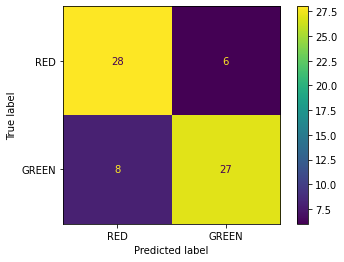


None: Classification Report
              precision    recall  f1-score   support

         RED       0.78      0.82      0.80        34
       GREEN       0.82      0.77      0.79        35

    accuracy                           0.80        69
   macro avg       0.80      0.80      0.80        69
weighted avg       0.80      0.80      0.80        69



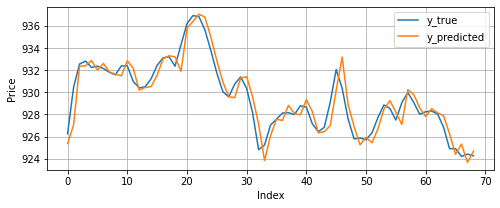

In [ ]:
y_predicted = publishModelScores(model_4_mlp, dataX_v, true_close, true_open
                   , label=None
                   , inverseScaling=inverseZscoreScaling
                   , nonScaled_dataX=nonScaled_dataX_v
                   , ema_alpha = ema_alpha
                   , previous_EMA = dataSupport_v[:,2]
                   , plotCharts=True
                   , returnYpredicted=True
                   )
